# **IMPORT LIBRARIES**

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import glob
from PIL import Image
from time import time

from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout,GlobalMaxPooling1D
#from keras.layers.wrappers import Bidirectional
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


# **Data loading and Preprocessing**

* toekn path contains image filenames and captions
* train images path contains training image filenames
* test images path contains testing image filenames

In [ ]:
token_path = "../input/flickr-8k/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '../input/flickr-8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '../input/flickr-8k/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '../input/flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset'


doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


**descriptions dictionary contains mapping for filenames and their list of 5 captions**

In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

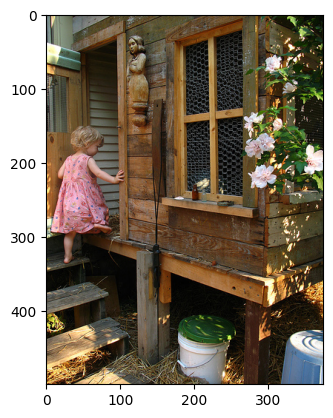

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

Next, we create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set. We have 9630 unique words across all the 40000 image captions.

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 9630


Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file:-

In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

Next, we load all training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file:-

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
doc = open(test_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

test = set(dataset)

Now we save all the training and testing images in train_img and test_img lists respectively:-

In [ ]:
img = glob.glob(images_path + '/*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i.split('/')[5] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i.split('/')[5] in test_images:
        test_img.append(i)

Now, we load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’:-

In [ ]:
train_descriptions = dict()
train_text=""
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)


In [ ]:
test_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in test:
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        test_descriptions[image_id].append(desc)


Create a list of all the training captions:-

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus.

If you have a dictionary, **get()** is a method where w is a variable holding the word you're looking up and 0 is the default value. If w is not present in the dictionary, get returns 0.

In [ ]:
text = ' '.join(sentence.replace('startseq ', '').replace(' endseq', '') for sentence in all_train_captions)

**Reducing the vocabulary size by half by keeping minimum word frequency threshold = 2**

In [ ]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 4728


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1


We also need to find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 40


**Glove Embeddings**

Word vectors map words to a **vector space, where similar words are clustered together and different words are separated**. The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

The basic premise behind Glove is **that we can derive semantic relationships between words from the co-occurrence matrix.**

In [ ]:
glove_path = '../input/glove6b/'

embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200

In [ ]:

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **Model Building and Training**

We must remember that we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model.

In [ ]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

Since we are using InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras.

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Now we can go ahead and encode our training and testing images

In [ ]:
from tqdm import tqdm
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    #print(fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    #print(fea_vec.shape)
    return fea_vec

encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img] = encode(img)



  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 1/6000 [00:04<8:17:08,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 3/6000 [00:05<2:15:03,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 5/6000 [00:05<1:09:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 7/6000 [00:05<43:20,  2.30it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 9/6000 [00:05<29:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 11/6000 [00:05<22:07,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 13/6000 [00:05<17:23,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 15/6000 [00:06<14:17,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 17/6000 [00:06<12:12,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 19/6000 [00:06<10:50,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 21/6000 [00:06<09:52, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 23/6000 [00:06<09:12, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 25/6000 [00:06<08:46, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 27/6000 [00:07<08:25, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 29/6000 [00:07<08:13, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 31/6000 [00:07<08:19, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 33/6000 [00:07<08:05, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 35/6000 [00:07<07:55, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 37/6000 [00:07<08:03, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 39/6000 [00:07<07:56, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 41/6000 [00:08<07:51, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 43/6000 [00:08<07:52, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 45/6000 [00:08<07:49, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 47/6000 [00:08<07:46, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 49/6000 [00:08<07:47, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 51/6000 [00:08<07:50, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 53/6000 [00:09<07:45, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 55/6000 [00:09<07:42, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 57/6000 [00:09<07:45, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 59/6000 [00:09<07:39, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 61/6000 [00:09<07:40, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 63/6000 [00:09<07:42, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|          | 65/6000 [00:09<07:43, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 67/6000 [00:10<07:42, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 69/6000 [00:10<07:42, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 71/6000 [00:10<07:53, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  1%|          | 73/6000 [00:10<07:53, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 75/6000 [00:10<07:53, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 77/6000 [00:10<08:10, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 79/6000 [00:11<08:01, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 81/6000 [00:11<07:54, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 83/6000 [00:11<07:44, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 85/6000 [00:11<07:47, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 87/6000 [00:11<07:49, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|▏         | 89/6000 [00:11<07:55, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 91/6000 [00:12<08:03, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 93/6000 [00:12<07:59, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 95/6000 [00:12<07:53, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 97/6000 [00:12<07:56, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 99/6000 [00:12<07:51, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 101/6000 [00:12<07:54, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 103/6000 [00:13<07:50, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 105/6000 [00:13<07:46, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 107/6000 [00:13<07:41, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 109/6000 [00:13<07:40, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 111/6000 [00:13<07:39, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 113/6000 [00:13<07:41, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 115/6000 [00:13<07:41, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 117/6000 [00:14<07:37, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 119/6000 [00:14<07:31, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 121/6000 [00:14<07:36, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 123/6000 [00:14<07:41, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 125/6000 [00:14<07:41, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 127/6000 [00:14<07:33, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 129/6000 [00:15<07:34, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 131/6000 [00:15<07:33, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 133/6000 [00:15<07:35, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 135/6000 [00:15<07:34, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 137/6000 [00:15<07:31, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 139/6000 [00:15<07:31, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 141/6000 [00:15<07:34, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 143/6000 [00:16<07:31, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 145/6000 [00:16<07:33, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 147/6000 [00:16<07:36, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 149/6000 [00:16<07:31, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 151/6000 [00:16<07:31, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 153/6000 [00:16<07:29, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 155/6000 [00:17<07:27, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 157/6000 [00:17<07:32, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 159/6000 [00:17<07:36, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 161/6000 [00:17<07:36, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  3%|▎         | 163/6000 [00:17<07:57, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 165/6000 [00:17<08:07, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  3%|▎         | 167/6000 [00:18<08:10, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 169/6000 [00:18<08:03, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 171/6000 [00:18<08:18, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 173/6000 [00:18<08:11, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 175/6000 [00:18<08:00, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 177/6000 [00:18<07:54, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 179/6000 [00:19<07:58, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|▎         | 181/6000 [00:19<08:04, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 183/6000 [00:19<08:09, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 185/6000 [00:19<08:10, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 187/6000 [00:19<08:07, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 189/6000 [00:19<08:01, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 191/6000 [00:20<08:01, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 193/6000 [00:20<08:03, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 195/6000 [00:20<07:52, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 197/6000 [00:20<07:49, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 199/6000 [00:20<07:43, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 201/6000 [00:20<07:37, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 203/6000 [00:20<07:30, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 205/6000 [00:21<07:30, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 207/6000 [00:21<07:29, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 209/6000 [00:21<07:26, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 211/6000 [00:21<07:31, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▎         | 213/6000 [00:21<07:38, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 215/6000 [00:21<07:58, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 217/6000 [00:22<08:03, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 219/6000 [00:22<07:56, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▎         | 221/6000 [00:22<07:50, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 223/6000 [00:22<07:46, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 225/6000 [00:22<07:37, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 227/6000 [00:22<07:32, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 229/6000 [00:23<07:31, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 231/6000 [00:23<07:28, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 233/6000 [00:23<07:26, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 235/6000 [00:23<07:25, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 237/6000 [00:23<07:24, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 239/6000 [00:23<07:29, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 241/6000 [00:24<07:31, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 243/6000 [00:24<07:36, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 245/6000 [00:24<07:31, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 247/6000 [00:24<07:26, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 249/6000 [00:24<07:26, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|▍         | 251/6000 [00:24<07:26, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 253/6000 [00:24<07:31, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 255/6000 [00:25<07:36, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 257/6000 [00:25<07:46, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  4%|▍         | 259/6000 [00:25<08:08, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 261/6000 [00:25<08:05, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 263/6000 [00:25<08:01, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 265/6000 [00:25<07:56, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 267/6000 [00:26<07:49, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 269/6000 [00:26<07:41, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 271/6000 [00:26<07:34, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 273/6000 [00:26<07:33, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 275/6000 [00:26<07:29, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 277/6000 [00:26<07:29, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 279/6000 [00:27<07:38, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 281/6000 [00:27<07:33, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 283/6000 [00:27<07:27, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▍         | 285/6000 [00:27<07:18, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 287/6000 [00:27<07:14, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 289/6000 [00:27<07:19, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 291/6000 [00:27<07:20, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 293/6000 [00:28<07:42, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 295/6000 [00:28<07:52, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|▍         | 297/6000 [00:28<07:55, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 299/6000 [00:28<07:53, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 301/6000 [00:28<07:48, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 303/6000 [00:28<07:36, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 305/6000 [00:29<07:33, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 307/6000 [00:29<07:34, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 309/6000 [00:29<07:28, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 311/6000 [00:29<07:25, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  5%|▌         | 313/6000 [00:29<07:31, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 315/6000 [00:29<07:30, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 317/6000 [00:30<07:27, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 319/6000 [00:30<07:22, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 321/6000 [00:30<07:17, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 323/6000 [00:30<07:21, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 325/6000 [00:30<07:26, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 327/6000 [00:30<07:27, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 329/6000 [00:31<07:25, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 331/6000 [00:31<07:21, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 333/6000 [00:31<07:18, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 335/6000 [00:31<07:16, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 337/6000 [00:31<07:23, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 339/6000 [00:31<07:23, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▌         | 341/6000 [00:31<07:43, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 343/6000 [00:32<07:36, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 345/6000 [00:32<07:24, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 347/6000 [00:32<07:18, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 349/6000 [00:32<07:18, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 351/6000 [00:32<07:16, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 353/6000 [00:32<07:19, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 355/6000 [00:33<07:16, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 357/6000 [00:33<07:13, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 359/6000 [00:33<07:06, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 361/6000 [00:33<07:12, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 363/6000 [00:33<07:14, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 365/6000 [00:33<07:13, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 367/6000 [00:33<07:12, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 369/6000 [00:34<07:11, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 371/6000 [00:34<07:09, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 373/6000 [00:34<07:17, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 375/6000 [00:34<07:15, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 377/6000 [00:34<07:17, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 379/6000 [00:34<07:15, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 381/6000 [00:35<07:16, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 383/6000 [00:35<07:24, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 385/6000 [00:35<07:26, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▋         | 387/6000 [00:35<07:36, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▋         | 389/6000 [00:35<07:32, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 391/6000 [00:35<07:29, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 393/6000 [00:36<07:21, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 395/6000 [00:36<07:21, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 397/6000 [00:36<07:19, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 399/6000 [00:36<07:18, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 401/6000 [00:36<07:19, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 403/6000 [00:36<07:17, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 405/6000 [00:36<07:18, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 407/6000 [00:37<07:21, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 409/6000 [00:37<07:20, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 411/6000 [00:37<07:19, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 413/6000 [00:37<07:18, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 415/6000 [00:37<07:18, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 417/6000 [00:37<07:18, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 419/6000 [00:38<07:14, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 421/6000 [00:38<07:16, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 423/6000 [00:38<07:15, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  7%|▋         | 425/6000 [00:38<07:25, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 427/6000 [00:38<07:31, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  7%|▋         | 429/6000 [00:38<07:37, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 431/6000 [00:39<07:30, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 433/6000 [00:39<07:35, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  7%|▋         | 435/6000 [00:39<07:38, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 437/6000 [00:39<07:39, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 439/6000 [00:39<07:41, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 441/6000 [00:39<07:35, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 443/6000 [00:40<07:36, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 445/6000 [00:40<07:35, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 447/6000 [00:40<07:42, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 449/6000 [00:40<07:41, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 451/6000 [00:40<07:37, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 453/6000 [00:40<07:28, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 455/6000 [00:40<07:29, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 457/6000 [00:41<07:27, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 459/6000 [00:41<07:34, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 461/6000 [00:41<07:32, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 463/6000 [00:41<07:30, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 465/6000 [00:41<07:42, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 467/6000 [00:42<07:53, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 469/6000 [00:42<07:51, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 471/6000 [00:42<07:41, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 473/6000 [00:42<07:34, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 475/6000 [00:42<07:29, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 477/6000 [00:42<07:24, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 479/6000 [00:42<07:17, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 481/6000 [00:43<07:24, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 483/6000 [00:43<07:27, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 485/6000 [00:43<07:29, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 487/6000 [00:43<07:28, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 489/6000 [00:43<07:24, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 491/6000 [00:43<07:23, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 493/6000 [00:44<07:36, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 495/6000 [00:44<07:29, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 497/6000 [00:44<07:19, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 499/6000 [00:44<07:16, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 501/6000 [00:44<07:14, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 503/6000 [00:44<07:11, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 505/6000 [00:45<07:14, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 507/6000 [00:45<07:16, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 509/6000 [00:45<07:13, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 511/6000 [00:45<07:12, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▊         | 513/6000 [00:45<07:10, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 515/6000 [00:45<07:07, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 517/6000 [00:45<07:10, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 519/6000 [00:46<07:10, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 521/6000 [00:46<07:09, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 523/6000 [00:46<07:07, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 525/6000 [00:46<07:04, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 527/6000 [00:46<07:00, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 529/6000 [00:46<07:02, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 531/6000 [00:47<07:15, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 533/6000 [00:47<07:12, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 535/6000 [00:47<07:06, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 537/6000 [00:47<07:05, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 539/6000 [00:47<07:01, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 541/6000 [00:47<07:01, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 543/6000 [00:48<07:04, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 545/6000 [00:48<07:08, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 547/6000 [00:48<07:09, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 549/6000 [00:48<07:06, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 551/6000 [00:48<07:02, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 553/6000 [00:48<07:03, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 555/6000 [00:48<07:05, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 557/6000 [00:49<07:06, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 559/6000 [00:49<07:04, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 561/6000 [00:49<07:04, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▉         | 563/6000 [00:49<07:03, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 565/6000 [00:49<07:07, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|▉         | 567/6000 [00:49<07:14, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 569/6000 [00:50<07:14, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 571/6000 [00:50<07:14, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 573/6000 [00:50<07:06, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 575/6000 [00:50<07:07, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 577/6000 [00:50<07:08, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 579/6000 [00:50<07:08, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 581/6000 [00:51<07:07, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 583/6000 [00:51<07:19, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 585/6000 [00:51<07:24, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|▉         | 587/6000 [00:51<07:16, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 589/6000 [00:51<07:30, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|▉         | 591/6000 [00:52<12:22,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|▉         | 593/6000 [00:52<10:52,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|▉         | 595/6000 [00:52<09:52,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|▉         | 597/6000 [00:52<09:14,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|▉         | 599/6000 [00:52<08:43, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|█         | 601/6000 [00:53<08:27, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|█         | 603/6000 [00:53<08:16, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 605/6000 [00:53<07:59, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 607/6000 [00:53<07:51, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|█         | 609/6000 [00:53<07:47, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 611/6000 [00:53<07:43, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|█         | 613/6000 [00:54<08:01, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 615/6000 [00:54<07:55, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 617/6000 [00:54<07:55, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 619/6000 [00:54<07:46, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 621/6000 [00:54<07:57, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 623/6000 [00:54<07:50, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 625/6000 [00:55<07:47, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|█         | 627/6000 [00:55<07:53, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 629/6000 [00:55<07:46, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 631/6000 [00:55<07:46, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 633/6000 [00:55<07:40, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 635/6000 [00:56<07:38, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 637/6000 [00:56<07:44, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 639/6000 [00:56<07:59, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 641/6000 [00:56<08:09, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 643/6000 [00:56<08:01, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 11%|█         | 645/6000 [00:56<07:53, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 647/6000 [00:57<07:48, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 649/6000 [00:57<07:42, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 651/6000 [00:57<07:40, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 653/6000 [00:57<07:38, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 655/6000 [00:57<07:31, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 657/6000 [00:57<07:28, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 659/6000 [00:58<07:25, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 661/6000 [00:58<07:23, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 663/6000 [00:58<07:25, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 665/6000 [00:58<07:20, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 667/6000 [00:58<07:19, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 669/6000 [00:58<07:16, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█         | 671/6000 [00:59<07:20, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 673/6000 [00:59<08:48, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█▏        | 675/6000 [00:59<09:23,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█▏        | 677/6000 [00:59<08:52,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 679/6000 [00:59<08:49, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█▏        | 681/6000 [01:00<08:30, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█▏        | 683/6000 [01:00<08:13, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█▏        | 685/6000 [01:00<08:04, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█▏        | 687/6000 [01:00<08:01, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 11%|█▏        | 689/6000 [01:00<07:55, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 691/6000 [01:01<07:58, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 693/6000 [01:01<07:49, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 695/6000 [01:01<07:43, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 697/6000 [01:01<07:41, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 699/6000 [01:01<07:52, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 701/6000 [01:01<07:56, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 703/6000 [01:02<08:13, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 705/6000 [01:02<08:01, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 707/6000 [01:02<07:50, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 709/6000 [01:02<07:38, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 711/6000 [01:02<07:40, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 713/6000 [01:02<07:40, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 715/6000 [01:03<07:38, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 717/6000 [01:03<07:35, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 719/6000 [01:03<07:31, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 721/6000 [01:03<07:29, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 723/6000 [01:03<07:37, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 725/6000 [01:03<07:44, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 727/6000 [01:04<08:01, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 729/6000 [01:04<07:55, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 731/6000 [01:04<07:57, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 733/6000 [01:04<07:49, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 735/6000 [01:04<07:48, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 737/6000 [01:05<07:49, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 739/6000 [01:05<07:57, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 741/6000 [01:05<07:47, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 743/6000 [01:05<07:38, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 745/6000 [01:05<07:29, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 747/6000 [01:05<07:32, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 749/6000 [01:06<07:34, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 751/6000 [01:06<07:32, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 753/6000 [01:06<07:28, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 755/6000 [01:06<07:27, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 757/6000 [01:06<07:45, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 759/6000 [01:06<07:51, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 761/6000 [01:07<07:47, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 763/6000 [01:07<07:36, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 765/6000 [01:07<07:29, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 767/6000 [01:07<07:30, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 769/6000 [01:07<07:29, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 771/6000 [01:08<07:40, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 773/6000 [01:08<07:35, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 775/6000 [01:08<07:28, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 777/6000 [01:08<07:24, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 779/6000 [01:08<07:28, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 781/6000 [01:08<07:22, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 783/6000 [01:09<07:42, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 785/6000 [01:09<07:34, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 787/6000 [01:09<07:25, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 789/6000 [01:09<07:18, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 791/6000 [01:09<07:17, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 793/6000 [01:09<07:15, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|█▎        | 795/6000 [01:10<07:28, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 797/6000 [01:10<07:27, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 799/6000 [01:10<07:31, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 801/6000 [01:10<07:27, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 803/6000 [01:10<07:25, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 805/6000 [01:10<07:20, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 13%|█▎        | 807/6000 [01:11<07:25, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 809/6000 [01:11<07:20, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 811/6000 [01:11<07:15, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▎        | 813/6000 [01:11<07:27, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 815/6000 [01:11<07:24, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▎        | 817/6000 [01:12<08:41,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 819/6000 [01:12<08:14, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 821/6000 [01:12<07:50, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 823/6000 [01:12<07:31, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 825/6000 [01:12<07:23, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 827/6000 [01:12<07:11, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 829/6000 [01:13<07:06, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 831/6000 [01:13<07:07, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 833/6000 [01:13<07:06, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 835/6000 [01:13<07:03, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 837/6000 [01:13<07:06, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 839/6000 [01:13<07:00, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 841/6000 [01:14<06:59, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 843/6000 [01:14<07:08, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 14%|█▍        | 845/6000 [01:14<07:09, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 847/6000 [01:14<07:09, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 849/6000 [01:14<07:08, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 851/6000 [01:14<07:09, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 853/6000 [01:15<07:07, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 855/6000 [01:15<07:12, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 857/6000 [01:15<07:16, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 859/6000 [01:15<07:12, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 861/6000 [01:15<07:16, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 863/6000 [01:15<07:07, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 865/6000 [01:16<07:05, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 867/6000 [01:16<07:06, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 869/6000 [01:16<07:03, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 871/6000 [01:16<07:05, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 873/6000 [01:16<07:00, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 875/6000 [01:16<06:58, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 877/6000 [01:16<06:52, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▍        | 879/6000 [01:17<06:57, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 881/6000 [01:17<06:56, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 883/6000 [01:17<06:54, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 885/6000 [01:17<06:57, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 887/6000 [01:17<06:58, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 889/6000 [01:17<06:53, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 891/6000 [01:18<06:57, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 893/6000 [01:18<06:57, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 895/6000 [01:18<06:58, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 897/6000 [01:18<07:02, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▍        | 899/6000 [01:18<06:59, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 901/6000 [01:18<06:53, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 903/6000 [01:19<07:05, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 905/6000 [01:19<07:01, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 907/6000 [01:19<07:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 909/6000 [01:19<07:01, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 911/6000 [01:19<06:59, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 913/6000 [01:19<06:59, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 915/6000 [01:20<07:05, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 917/6000 [01:20<07:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 919/6000 [01:20<06:58, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 921/6000 [01:20<07:01, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 923/6000 [01:20<06:58, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 925/6000 [01:20<07:01, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 927/6000 [01:21<07:02, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 929/6000 [01:21<07:06, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 931/6000 [01:21<06:59, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 933/6000 [01:21<07:01, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 935/6000 [01:21<07:04, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 937/6000 [01:21<07:14, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 939/6000 [01:22<07:15, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 941/6000 [01:22<07:09, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 943/6000 [01:22<07:05, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 945/6000 [01:22<07:09, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 947/6000 [01:22<07:03, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 949/6000 [01:22<06:55, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 951/6000 [01:23<07:05, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 16%|█▌        | 953/6000 [01:23<07:05, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 955/6000 [01:23<07:07, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 957/6000 [01:23<07:07, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 959/6000 [01:23<07:02, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 961/6000 [01:23<06:59, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▌        | 963/6000 [01:24<07:04, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 965/6000 [01:24<07:00, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 967/6000 [01:24<07:06, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 969/6000 [01:24<07:02, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 971/6000 [01:24<06:57, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 973/6000 [01:24<06:51, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 975/6000 [01:25<06:58, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 977/6000 [01:25<06:54, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 979/6000 [01:25<06:52, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 981/6000 [01:25<06:55, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 983/6000 [01:25<06:54, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▋        | 985/6000 [01:25<06:46, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 16%|█▋        | 987/6000 [01:26<06:57, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▋        | 989/6000 [01:26<07:00, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 991/6000 [01:26<07:03, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 993/6000 [01:26<07:05, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 995/6000 [01:26<06:57, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 17%|█▋        | 997/6000 [01:26<07:01, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 999/6000 [01:27<07:17, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1001/6000 [01:27<07:13, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1003/6000 [01:27<07:10, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1005/6000 [01:27<07:10, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1007/6000 [01:27<07:01, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1009/6000 [01:28<06:53, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1011/6000 [01:28<06:55, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1013/6000 [01:28<06:55, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1015/6000 [01:28<06:52, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1017/6000 [01:28<06:49, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1019/6000 [01:28<06:45, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1021/6000 [01:28<06:42, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1023/6000 [01:29<06:49, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1025/6000 [01:29<06:48, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1027/6000 [01:29<06:49, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1029/6000 [01:29<06:51, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1031/6000 [01:29<06:47, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 1033/6000 [01:29<06:47, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 1035/6000 [01:30<06:51, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 1037/6000 [01:30<06:47, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 17%|█▋        | 1039/6000 [01:30<06:58, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 1041/6000 [01:30<07:15, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1043/6000 [01:30<07:15, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1045/6000 [01:31<07:10, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 17%|█▋        | 1047/6000 [01:31<07:13, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 17%|█▋        | 1049/6000 [01:31<07:14, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|█▊        | 1051/6000 [01:31<07:04, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1053/6000 [01:31<07:00, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1055/6000 [01:31<06:56, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1057/6000 [01:32<07:04, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1059/6000 [01:32<07:01, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1061/6000 [01:32<07:02, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1063/6000 [01:32<06:54, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1065/6000 [01:32<06:55, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1067/6000 [01:32<06:56, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1069/6000 [01:33<06:52, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|█▊        | 1071/6000 [01:33<06:55, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1073/6000 [01:33<06:56, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1075/6000 [01:33<07:06, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1077/6000 [01:33<06:59, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1079/6000 [01:33<06:54, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1081/6000 [01:34<06:48, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1083/6000 [01:34<06:51, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1085/6000 [01:34<06:52, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1087/6000 [01:34<06:51, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1089/6000 [01:34<06:51, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1091/6000 [01:34<06:49, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 18%|█▊        | 1093/6000 [01:35<06:52, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1095/6000 [01:35<07:01, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1097/6000 [01:35<06:55, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1099/6000 [01:35<06:50, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1101/6000 [01:35<06:48, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 1103/6000 [01:35<06:43, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 1105/6000 [01:36<06:37, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1107/6000 [01:36<06:56, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 1109/6000 [01:36<06:51, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1111/6000 [01:36<06:47, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 1113/6000 [01:36<06:46, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 1115/6000 [01:36<06:39, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1117/6000 [01:37<06:34, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▊        | 1119/6000 [01:37<06:47, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1121/6000 [01:37<06:50, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 1123/6000 [01:37<06:47, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1125/6000 [01:37<06:43, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 1127/6000 [01:37<06:40, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1129/6000 [01:38<06:36, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1131/6000 [01:38<06:38, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1133/6000 [01:38<06:37, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 1135/6000 [01:38<06:46, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1137/6000 [01:38<06:59, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 19%|█▉        | 1139/6000 [01:38<07:05, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1141/6000 [01:39<07:03, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1143/6000 [01:39<07:02, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 1145/6000 [01:39<06:54, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1147/6000 [01:39<06:50, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1149/6000 [01:39<06:48, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1151/6000 [01:39<06:49, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1153/6000 [01:40<06:44, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 1155/6000 [01:40<06:51, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1157/6000 [01:40<06:56, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 19%|█▉        | 1159/6000 [01:40<07:02, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1161/6000 [01:40<06:51, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1163/6000 [01:40<06:41, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 1165/6000 [01:41<06:36, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1167/6000 [01:41<06:39, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 1169/6000 [01:41<06:41, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1171/6000 [01:41<06:42, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 1173/6000 [01:41<06:59, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|█▉        | 1175/6000 [01:41<07:08, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1177/6000 [01:42<06:59, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1179/6000 [01:42<06:59, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|█▉        | 1181/6000 [01:42<07:07, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1183/6000 [01:42<07:00, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|█▉        | 1185/6000 [01:42<06:54, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|█▉        | 1187/6000 [01:43<06:44, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 1189/6000 [01:43<06:42, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1191/6000 [01:43<06:49, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|█▉        | 1193/6000 [01:43<06:52, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|█▉        | 1195/6000 [01:43<06:51, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 1197/6000 [01:43<06:49, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 1199/6000 [01:44<06:41, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1201/6000 [01:44<06:37, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1203/6000 [01:44<06:38, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1205/6000 [01:44<06:36, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|██        | 1207/6000 [01:44<06:38, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1209/6000 [01:44<06:36, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1211/6000 [01:45<06:34, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 1213/6000 [01:45<06:33, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|██        | 1215/6000 [01:45<06:42, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|██        | 1217/6000 [01:45<06:42, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1219/6000 [01:45<06:50, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1221/6000 [01:45<06:49, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 1223/6000 [01:46<06:53, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1225/6000 [01:46<06:52, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1227/6000 [01:46<06:51, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 1229/6000 [01:46<07:31, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1231/6000 [01:46<07:18, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1233/6000 [01:46<07:09, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1235/6000 [01:47<06:55, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 1237/6000 [01:47<06:44, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1239/6000 [01:47<06:43, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1241/6000 [01:47<06:41, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1243/6000 [01:47<06:38, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1245/6000 [01:47<06:34, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1247/6000 [01:48<06:30, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1249/6000 [01:48<06:26, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1251/6000 [01:48<06:30, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1253/6000 [01:48<06:29, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1255/6000 [01:48<06:29, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1257/6000 [01:48<06:26, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1259/6000 [01:49<06:25, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1261/6000 [01:49<06:19, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1263/6000 [01:49<06:32, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 21%|██        | 1265/6000 [01:49<06:31, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 1267/6000 [01:49<06:31, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1269/6000 [01:49<06:30, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 1271/6000 [01:50<06:26, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 1273/6000 [01:50<06:28, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 21%|██▏       | 1275/6000 [01:50<06:37, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 21%|██▏       | 1277/6000 [01:50<06:46, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 1279/6000 [01:50<06:39, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 1281/6000 [01:50<06:37, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 1283/6000 [01:51<06:32, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██▏       | 1285/6000 [01:51<06:25, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██▏       | 1287/6000 [01:51<06:29, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██▏       | 1289/6000 [01:51<06:31, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 1291/6000 [01:51<06:42, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 1293/6000 [01:51<06:44, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1295/6000 [01:52<06:37, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1297/6000 [01:52<06:34, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1299/6000 [01:52<06:33, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1301/6000 [01:52<06:31, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1303/6000 [01:52<06:28, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1305/6000 [01:52<06:31, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1307/6000 [01:53<06:26, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1309/6000 [01:53<06:21, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1311/6000 [01:53<06:27, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1313/6000 [01:53<06:27, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1315/6000 [01:53<06:29, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1317/6000 [01:53<06:34, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1319/6000 [01:54<06:33, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1321/6000 [01:54<06:27, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1323/6000 [01:54<06:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1325/6000 [01:54<06:49, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1327/6000 [01:54<06:48, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1329/6000 [01:54<06:41, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 22%|██▏       | 1331/6000 [01:55<06:37, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1333/6000 [01:55<06:30, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1335/6000 [01:55<06:37, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1337/6000 [01:55<06:37, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 1339/6000 [01:55<06:49, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1341/6000 [01:55<06:39, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1343/6000 [01:56<06:31, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 1345/6000 [01:56<06:24, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1347/6000 [01:56<06:32, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 1349/6000 [01:56<06:31, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1351/6000 [01:56<06:28, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1353/6000 [01:56<06:25, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1355/6000 [01:57<06:21, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 1357/6000 [01:57<06:17, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1359/6000 [01:57<06:20, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1361/6000 [01:57<06:35, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██▎       | 1363/6000 [01:57<06:38, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1365/6000 [01:58<06:41, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1367/6000 [01:58<06:38, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1369/6000 [01:58<06:28, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1371/6000 [01:58<06:31, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1373/6000 [01:58<06:25, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 1375/6000 [01:58<06:23, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1377/6000 [01:58<06:21, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1379/6000 [01:59<06:17, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1381/6000 [01:59<06:12, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1383/6000 [01:59<06:29, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1385/6000 [01:59<06:33, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1387/6000 [01:59<06:33, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1389/6000 [02:00<06:33, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1391/6000 [02:00<06:25, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1393/6000 [02:00<06:23, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1395/6000 [02:00<06:25, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 23%|██▎       | 1397/6000 [02:00<06:27, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1399/6000 [02:00<06:30, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1401/6000 [02:01<06:24, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 1403/6000 [02:01<06:22, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 1405/6000 [02:01<06:16, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 23%|██▎       | 1407/6000 [02:01<06:27, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 1409/6000 [02:01<06:24, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 1411/6000 [02:01<06:52, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 24%|██▎       | 1413/6000 [02:02<07:16, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▎       | 1415/6000 [02:02<07:16, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▎       | 1417/6000 [02:02<06:57, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▎       | 1419/6000 [02:02<06:59, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▎       | 1421/6000 [02:02<06:53, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▎       | 1423/6000 [02:02<06:40, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1425/6000 [02:03<06:31, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1427/6000 [02:03<06:21, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1429/6000 [02:03<06:12, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1431/6000 [02:03<06:15, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1433/6000 [02:03<06:15, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1435/6000 [02:03<06:15, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1437/6000 [02:04<06:14, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1439/6000 [02:04<06:12, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1441/6000 [02:04<06:09, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1443/6000 [02:04<06:11, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1445/6000 [02:04<06:15, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1447/6000 [02:04<06:11, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▍       | 1449/6000 [02:05<06:26, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1451/6000 [02:05<06:22, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1453/6000 [02:05<06:13, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1455/6000 [02:05<06:14, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1457/6000 [02:05<06:14, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 1459/6000 [02:05<06:20, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1461/6000 [02:06<06:16, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 1463/6000 [02:06<06:12, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▍       | 1465/6000 [02:06<06:05, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 1467/6000 [02:06<06:14, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 24%|██▍       | 1469/6000 [02:06<06:18, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1471/6000 [02:06<06:17, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1473/6000 [02:07<06:13, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1475/6000 [02:07<06:15, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 1477/6000 [02:07<06:12, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 1479/6000 [02:07<06:14, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1481/6000 [02:07<06:13, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1483/6000 [02:07<06:16, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1485/6000 [02:08<06:14, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 1487/6000 [02:08<06:09, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 1489/6000 [02:08<06:05, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 1491/6000 [02:08<06:08, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1493/6000 [02:08<06:07, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▍       | 1495/6000 [02:08<06:12, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 1497/6000 [02:09<06:20, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 1499/6000 [02:09<06:18, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 1501/6000 [02:09<06:08, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 1503/6000 [02:09<06:11, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 1505/6000 [02:09<06:11, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 1507/6000 [02:09<06:11, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 1509/6000 [02:10<06:15, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 1511/6000 [02:10<06:09, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 25%|██▌       | 1513/6000 [02:10<06:16, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 1515/6000 [02:10<06:18, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 1517/6000 [02:10<06:30, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 1519/6000 [02:10<06:23, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 1521/6000 [02:11<06:16, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 1523/6000 [02:11<06:08, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 1525/6000 [02:11<06:02, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 1527/6000 [02:11<06:10, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▌       | 1529/6000 [02:11<06:12, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▌       | 1531/6000 [02:11<06:13, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1533/6000 [02:12<06:18, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1535/6000 [02:12<06:12, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1537/6000 [02:12<06:05, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1539/6000 [02:12<06:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1541/6000 [02:12<06:11, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1543/6000 [02:12<06:13, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1545/6000 [02:13<06:09, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1547/6000 [02:13<06:07, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1549/6000 [02:13<06:05, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 1551/6000 [02:13<06:11, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 1553/6000 [02:13<06:16, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1555/6000 [02:13<06:10, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1557/6000 [02:14<06:11, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1559/6000 [02:14<06:08, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1561/6000 [02:14<06:05, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 1563/6000 [02:14<06:08, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 1565/6000 [02:14<06:23, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 1567/6000 [02:14<06:19, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1569/6000 [02:15<06:12, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1571/6000 [02:15<06:07, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 1573/6000 [02:15<06:00, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 1575/6000 [02:15<06:05, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 1577/6000 [02:15<06:07, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 1579/6000 [02:15<06:05, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 1581/6000 [02:16<06:09, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 1583/6000 [02:16<06:04, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▋       | 1585/6000 [02:16<06:01, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 1587/6000 [02:16<06:06, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▋       | 1589/6000 [02:16<06:08, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1591/6000 [02:16<06:08, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1593/6000 [02:17<06:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1595/6000 [02:17<06:09, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1597/6000 [02:17<06:05, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1599/6000 [02:17<06:06, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1601/6000 [02:17<06:06, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1603/6000 [02:17<06:06, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1605/6000 [02:18<06:01, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1607/6000 [02:18<05:59, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1609/6000 [02:18<05:56, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1611/6000 [02:18<05:55, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1613/6000 [02:18<05:56, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1615/6000 [02:18<05:55, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1617/6000 [02:19<05:55, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1619/6000 [02:19<05:55, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 1621/6000 [02:19<05:53, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1623/6000 [02:19<05:56, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1625/6000 [02:19<05:55, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1627/6000 [02:19<05:56, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1629/6000 [02:20<05:53, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1631/6000 [02:20<05:55, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 1633/6000 [02:20<05:52, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1635/6000 [02:20<05:57, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1637/6000 [02:20<05:59, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1639/6000 [02:20<06:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1641/6000 [02:21<06:04, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 1643/6000 [02:21<06:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 1645/6000 [02:21<05:54, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 1647/6000 [02:21<05:58, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 1649/6000 [02:21<05:58, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1651/6000 [02:21<06:11, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1653/6000 [02:22<06:14, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1655/6000 [02:22<06:06, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1657/6000 [02:22<06:00, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1659/6000 [02:22<06:03, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1661/6000 [02:22<06:01, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1663/6000 [02:22<06:03, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1665/6000 [02:23<06:02, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1667/6000 [02:23<05:57, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1669/6000 [02:23<05:54, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1671/6000 [02:23<05:59, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1673/6000 [02:23<06:02, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1675/6000 [02:23<06:00, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1677/6000 [02:24<05:59, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1679/6000 [02:24<05:55, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1681/6000 [02:24<05:55, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 1683/6000 [02:24<06:01, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1685/6000 [02:24<06:08, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1687/6000 [02:24<06:04, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1689/6000 [02:25<05:57, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1691/6000 [02:25<06:01, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1693/6000 [02:25<05:54, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1695/6000 [02:25<05:57, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1697/6000 [02:25<06:01, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1699/6000 [02:25<05:59, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1701/6000 [02:26<05:56, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1703/6000 [02:26<05:50, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 1705/6000 [02:26<05:45, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 1707/6000 [02:26<05:53, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 1709/6000 [02:26<05:58, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▊       | 1711/6000 [02:26<05:58, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▊       | 1713/6000 [02:26<05:56, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 29%|██▊       | 1715/6000 [02:27<06:02, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▊       | 1717/6000 [02:27<06:09, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▊       | 1719/6000 [02:27<06:08, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▊       | 1721/6000 [02:27<06:04, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▊       | 1723/6000 [02:27<05:59, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1725/6000 [02:28<05:59, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 1727/6000 [02:28<05:54, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 1729/6000 [02:28<06:00, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 29%|██▉       | 1731/6000 [02:28<06:15, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 1733/6000 [02:28<06:23, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1735/6000 [02:28<06:19, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1737/6000 [02:29<06:12, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1739/6000 [02:29<06:07, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 1741/6000 [02:29<05:59, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1743/6000 [02:29<05:59, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 1745/6000 [02:29<05:57, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1747/6000 [02:29<05:51, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1749/6000 [02:30<06:04, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 1751/6000 [02:30<05:59, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 1753/6000 [02:30<05:51, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 1755/6000 [02:30<05:54, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 1757/6000 [02:30<06:07, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1759/6000 [02:30<06:01, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 1761/6000 [02:31<05:53, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 1763/6000 [02:31<05:45, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 1765/6000 [02:31<05:44, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 29%|██▉       | 1767/6000 [02:31<05:51, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|██▉       | 1769/6000 [02:31<05:58, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 1771/6000 [02:31<06:03, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 1773/6000 [02:32<06:00, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 1775/6000 [02:32<05:54, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 1777/6000 [02:32<05:49, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 1779/6000 [02:32<05:53, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 1781/6000 [02:32<05:50, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 1783/6000 [02:32<05:50, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|██▉       | 1785/6000 [02:33<05:57, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 1787/6000 [02:33<05:58, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 1789/6000 [02:33<05:56, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|██▉       | 1791/6000 [02:33<05:57, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 1793/6000 [02:33<05:57, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|██▉       | 1795/6000 [02:33<06:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 1797/6000 [02:34<06:01, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|██▉       | 1799/6000 [02:34<05:55, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 1801/6000 [02:34<05:47, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1803/6000 [02:34<05:47, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 1805/6000 [02:34<05:45, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1807/6000 [02:34<05:44, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 30%|███       | 1809/6000 [02:35<05:46, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 1811/6000 [02:35<05:52, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 1813/6000 [02:35<05:46, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1815/6000 [02:35<05:52, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1817/6000 [02:35<05:49, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1819/6000 [02:35<05:51, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 1821/6000 [02:36<05:51, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1823/6000 [02:36<05:49, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|███       | 1825/6000 [02:36<05:40, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1827/6000 [02:36<05:42, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 1829/6000 [02:36<05:41, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1831/6000 [02:36<05:41, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 1833/6000 [02:37<05:39, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 1835/6000 [02:37<05:33, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 1837/6000 [02:37<05:31, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1839/6000 [02:37<05:39, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1841/6000 [02:37<05:38, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1843/6000 [02:37<05:36, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 1845/6000 [02:38<05:33, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1847/6000 [02:38<05:32, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1849/6000 [02:38<05:32, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 31%|███       | 1851/6000 [02:38<05:42, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1853/6000 [02:38<05:44, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1855/6000 [02:38<05:43, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 1857/6000 [02:39<05:39, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1859/6000 [02:39<05:37, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 1861/6000 [02:39<05:36, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1863/6000 [02:39<05:38, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1865/6000 [02:39<05:39, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1867/6000 [02:39<05:42, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 1869/6000 [02:40<05:44, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 1871/6000 [02:40<05:42, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 1873/6000 [02:40<05:42, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███▏      | 1875/6000 [02:40<05:44, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 31%|███▏      | 1877/6000 [02:40<05:46, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███▏      | 1879/6000 [02:40<05:46, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███▏      | 1881/6000 [02:41<05:42, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███▏      | 1883/6000 [02:41<05:39, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███▏      | 1885/6000 [02:41<05:40, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 1887/6000 [02:41<05:41, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 1889/6000 [02:41<05:47, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1891/6000 [02:41<05:56, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1893/6000 [02:42<06:12, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1895/6000 [02:42<05:56, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 1897/6000 [02:42<05:46, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1899/6000 [02:42<05:58, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1901/6000 [02:42<05:53, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1903/6000 [02:42<05:47, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1905/6000 [02:43<05:44, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1907/6000 [02:43<05:38, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1909/6000 [02:43<05:35, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 1911/6000 [02:43<05:50, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1913/6000 [02:43<05:47, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1915/6000 [02:43<05:46, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1917/6000 [02:44<05:45, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1919/6000 [02:44<05:37, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1921/6000 [02:44<05:37, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 32%|███▏      | 1923/6000 [02:44<05:40, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1925/6000 [02:44<05:43, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1927/6000 [02:44<05:38, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1929/6000 [02:45<05:44, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1931/6000 [02:45<05:42, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1933/6000 [02:45<05:40, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 1935/6000 [02:45<05:41, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1937/6000 [02:45<05:46, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1939/6000 [02:45<05:43, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1941/6000 [02:46<05:42, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 1943/6000 [02:46<05:37, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███▏      | 1945/6000 [02:46<05:32, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1947/6000 [02:46<05:35, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 1949/6000 [02:46<05:36, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1951/6000 [02:46<05:31, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1953/6000 [02:47<05:30, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1955/6000 [02:47<05:44, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 1957/6000 [02:47<05:50, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 1959/6000 [02:47<05:47, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 1961/6000 [02:47<05:46, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 1963/6000 [02:47<05:42, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1965/6000 [02:48<05:47, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 1967/6000 [02:48<05:40, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1969/6000 [02:48<05:37, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1971/6000 [02:48<05:34, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1973/6000 [02:48<05:33, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1975/6000 [02:48<05:33, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1977/6000 [02:49<05:32, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1979/6000 [02:49<05:27, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1981/6000 [02:49<05:26, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 1983/6000 [02:49<05:29, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1985/6000 [02:49<05:29, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1987/6000 [02:49<05:30, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 1989/6000 [02:50<05:30, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1991/6000 [02:50<05:35, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 1993/6000 [02:50<05:34, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 1995/6000 [02:50<05:38, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 1997/6000 [02:50<05:37, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 1999/6000 [02:50<05:35, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 2001/6000 [02:51<05:33, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 2003/6000 [02:51<05:29, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 2005/6000 [02:51<05:25, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 33%|███▎      | 2007/6000 [02:51<05:31, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 33%|███▎      | 2009/6000 [02:51<05:34, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▎      | 2011/6000 [02:51<05:45, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2013/6000 [02:52<05:42, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2015/6000 [02:52<05:33, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2017/6000 [02:52<05:29, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2019/6000 [02:52<05:31, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▎      | 2021/6000 [02:52<05:35, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 2023/6000 [02:52<05:37, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2025/6000 [02:53<05:33, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2027/6000 [02:53<05:26, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 2029/6000 [02:53<05:20, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2031/6000 [02:53<05:26, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2033/6000 [02:53<05:33, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 34%|███▍      | 2035/6000 [02:53<05:44, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2037/6000 [02:54<05:47, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2039/6000 [02:54<05:37, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 2041/6000 [02:54<05:42, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 34%|███▍      | 2043/6000 [02:54<05:54, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2045/6000 [02:54<05:48, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2047/6000 [02:55<05:42, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2049/6000 [02:55<05:36, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2051/6000 [02:55<05:32, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2053/6000 [02:55<05:40, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2055/6000 [02:55<05:37, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2057/6000 [02:55<05:37, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2059/6000 [02:56<05:33, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 2061/6000 [02:56<05:32, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2063/6000 [02:56<05:28, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 2065/6000 [02:56<05:23, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 2067/6000 [02:56<05:26, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 2069/6000 [02:56<05:26, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2071/6000 [02:57<05:22, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▍      | 2073/6000 [02:57<05:24, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2075/6000 [02:57<05:23, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2077/6000 [02:57<05:21, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▍      | 2079/6000 [02:57<05:24, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2081/6000 [02:57<05:36, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2083/6000 [02:58<05:30, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 2085/6000 [02:58<05:27, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2087/6000 [02:58<05:21, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 2089/6000 [02:58<05:17, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2091/6000 [02:58<05:19, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2093/6000 [02:58<05:19, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 2095/6000 [02:59<05:17, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▍      | 2097/6000 [02:59<05:25, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 35%|███▍      | 2099/6000 [02:59<05:39, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2101/6000 [02:59<05:42, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2103/6000 [02:59<05:43, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2105/6000 [02:59<06:37,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 2107/6000 [03:00<06:16, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2109/6000 [03:00<05:57, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2111/6000 [03:00<05:45, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2113/6000 [03:00<05:36, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2115/6000 [03:00<05:37, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2117/6000 [03:00<05:35, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2119/6000 [03:01<05:34, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2121/6000 [03:01<05:38, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2123/6000 [03:01<05:31, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 2125/6000 [03:01<05:28, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 35%|███▌      | 2127/6000 [03:01<05:32, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 2129/6000 [03:02<05:44, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2131/6000 [03:02<05:36, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2133/6000 [03:02<05:30, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2135/6000 [03:02<05:25, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 2137/6000 [03:02<05:20, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2139/6000 [03:02<05:23, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 2141/6000 [03:03<05:25, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2143/6000 [03:03<05:22, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2145/6000 [03:03<05:19, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2147/6000 [03:03<05:16, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2149/6000 [03:03<05:17, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2151/6000 [03:03<05:18, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▌      | 2153/6000 [03:04<05:20, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 2155/6000 [03:04<05:19, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 2157/6000 [03:04<05:36, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 2159/6000 [03:04<05:37, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███▌      | 2161/6000 [03:04<05:38, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 36%|███▌      | 2163/6000 [03:04<05:39, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▌      | 2165/6000 [03:05<05:40, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▌      | 2167/6000 [03:05<05:44, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2169/6000 [03:05<05:38, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2171/6000 [03:05<05:27, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 2173/6000 [03:05<05:23, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▋      | 2175/6000 [03:05<05:25, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2177/6000 [03:06<05:26, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 36%|███▋      | 2179/6000 [03:06<05:23, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▋      | 2181/6000 [03:06<05:19, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2183/6000 [03:06<05:17, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2185/6000 [03:06<05:11, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2187/6000 [03:06<05:12, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 2189/6000 [03:07<05:11, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2191/6000 [03:07<05:10, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2193/6000 [03:07<05:11, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 2195/6000 [03:07<05:09, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2197/6000 [03:07<05:06, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2199/6000 [03:07<05:09, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2201/6000 [03:08<05:08, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2203/6000 [03:08<05:08, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2205/6000 [03:08<05:10, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2207/6000 [03:08<05:07, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 2209/6000 [03:08<05:05, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2211/6000 [03:08<05:09, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2213/6000 [03:09<05:10, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2215/6000 [03:09<05:10, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 37%|███▋      | 2217/6000 [03:09<05:11, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2219/6000 [03:09<05:14, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2221/6000 [03:09<05:17, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2223/6000 [03:09<05:19, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2225/6000 [03:10<05:20, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2227/6000 [03:10<05:24, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2229/6000 [03:10<05:30, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2231/6000 [03:10<05:19, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2233/6000 [03:10<05:13, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2235/6000 [03:10<05:13, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2237/6000 [03:11<05:13, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2239/6000 [03:11<05:11, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2241/6000 [03:11<05:12, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 2243/6000 [03:11<05:15, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 2245/6000 [03:11<05:12, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 2247/6000 [03:11<05:19, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 2249/6000 [03:12<05:21, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2251/6000 [03:12<05:17, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2253/6000 [03:12<05:12, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2255/6000 [03:12<05:09, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|███▊      | 2257/6000 [03:12<05:05, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2259/6000 [03:12<05:06, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2261/6000 [03:13<05:06, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2263/6000 [03:13<05:08, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2265/6000 [03:13<05:03, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2267/6000 [03:13<05:03, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2269/6000 [03:13<05:07, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 2271/6000 [03:13<05:07, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2273/6000 [03:14<05:08, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2275/6000 [03:14<05:05, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2277/6000 [03:14<05:02, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 2279/6000 [03:14<05:16, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2281/6000 [03:14<05:14, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2283/6000 [03:14<05:13, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 2285/6000 [03:15<05:14, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2287/6000 [03:15<05:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 2289/6000 [03:15<05:11, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2291/6000 [03:15<05:08, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2293/6000 [03:15<05:09, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 2295/6000 [03:15<05:10, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2297/6000 [03:16<05:13, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2299/6000 [03:16<05:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 2301/6000 [03:16<05:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2303/6000 [03:16<05:08, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 2305/6000 [03:16<05:05, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 2307/6000 [03:16<05:08, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 2309/6000 [03:17<05:08, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▊      | 2311/6000 [03:17<05:12, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▊      | 2313/6000 [03:17<05:13, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▊      | 2315/6000 [03:17<05:10, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▊      | 2317/6000 [03:17<05:07, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▊      | 2319/6000 [03:17<05:19, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▊      | 2321/6000 [03:18<05:19, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▊      | 2323/6000 [03:18<05:17, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 2325/6000 [03:18<05:12, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 2327/6000 [03:18<05:10, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2329/6000 [03:18<05:09, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 2331/6000 [03:18<05:11, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 2333/6000 [03:19<05:26, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2335/6000 [03:19<05:23, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2337/6000 [03:19<05:17, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 2339/6000 [03:19<05:50, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2341/6000 [03:19<05:36, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 39%|███▉      | 2343/6000 [03:20<05:37, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2345/6000 [03:20<05:37, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2347/6000 [03:20<05:28, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2349/6000 [03:20<05:20, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 2351/6000 [03:20<05:11, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 2353/6000 [03:20<05:08, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 2355/6000 [03:21<05:11, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2357/6000 [03:21<05:07, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2359/6000 [03:21<05:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2361/6000 [03:21<05:01, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2363/6000 [03:21<05:02, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|███▉      | 2365/6000 [03:21<05:08, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 2367/6000 [03:22<05:12, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▉      | 2369/6000 [03:22<05:07, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 2371/6000 [03:22<05:05, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 2373/6000 [03:22<05:02, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 2375/6000 [03:22<04:57, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 2377/6000 [03:22<04:52, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 2379/6000 [03:23<04:55, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 2381/6000 [03:23<04:58, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 2383/6000 [03:23<05:03, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 2385/6000 [03:23<04:57, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 2387/6000 [03:23<05:00, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|███▉      | 2389/6000 [03:23<04:55, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 2391/6000 [03:24<04:56, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 2393/6000 [03:24<04:56, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 2395/6000 [03:24<04:56, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 2397/6000 [03:24<05:05, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|███▉      | 2399/6000 [03:24<05:07, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 2401/6000 [03:24<05:04, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|████      | 2403/6000 [03:25<05:03, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 2405/6000 [03:25<05:01, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 2407/6000 [03:25<05:01, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 2409/6000 [03:25<05:01, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 2411/6000 [03:25<05:03, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 2413/6000 [03:25<04:56, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 2415/6000 [03:26<04:55, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 2417/6000 [03:26<05:06, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 2419/6000 [03:26<05:00, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 2421/6000 [03:26<04:57, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 2423/6000 [03:26<04:57, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|████      | 2425/6000 [03:26<04:51, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 2427/6000 [03:27<04:54, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 40%|████      | 2429/6000 [03:27<04:53, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2431/6000 [03:27<05:03, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2433/6000 [03:27<05:07, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2435/6000 [03:27<05:00, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2437/6000 [03:27<04:53, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2439/6000 [03:28<04:53, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2441/6000 [03:28<04:55, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2443/6000 [03:28<04:52, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2445/6000 [03:28<04:51, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2447/6000 [03:28<04:48, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 2449/6000 [03:28<04:45, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2451/6000 [03:29<04:50, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2453/6000 [03:29<04:55, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2455/6000 [03:29<04:50, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2457/6000 [03:29<04:50, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2459/6000 [03:29<04:50, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 41%|████      | 2461/6000 [03:29<04:54, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████      | 2463/6000 [03:30<05:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2465/6000 [03:30<04:58, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2467/6000 [03:30<04:55, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 2469/6000 [03:30<04:55, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████      | 2471/6000 [03:30<04:52, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 2473/6000 [03:30<04:47, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 2475/6000 [03:31<04:49, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████▏     | 2477/6000 [03:31<04:47, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 2479/6000 [03:31<04:48, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████▏     | 2481/6000 [03:31<04:46, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 41%|████▏     | 2483/6000 [03:31<04:44, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 2485/6000 [03:31<04:46, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████▏     | 2487/6000 [03:32<04:59, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 2489/6000 [03:32<04:55, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2491/6000 [03:32<04:51, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2493/6000 [03:32<04:50, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2495/6000 [03:32<04:44, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 2497/6000 [03:32<04:41, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2499/6000 [03:33<04:44, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2501/6000 [03:33<04:46, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2503/6000 [03:33<04:45, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2505/6000 [03:33<04:43, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2507/6000 [03:33<04:42, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 2509/6000 [03:33<04:40, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|████▏     | 2511/6000 [03:34<04:46, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2513/6000 [03:34<04:45, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2515/6000 [03:34<04:45, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2517/6000 [03:34<04:45, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2519/6000 [03:34<04:41, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2521/6000 [03:34<04:38, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2523/6000 [03:34<04:44, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 42%|████▏     | 2525/6000 [03:35<04:49, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2527/6000 [03:35<04:49, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2529/6000 [03:35<04:45, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 42%|████▏     | 2531/6000 [03:35<05:00, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|████▏     | 2533/6000 [03:35<04:59, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 2535/6000 [03:36<05:09, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 42%|████▏     | 2537/6000 [03:36<05:03, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2539/6000 [03:36<05:01, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 2541/6000 [03:36<04:55, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 2543/6000 [03:36<04:53, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 2545/6000 [03:36<04:48, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2547/6000 [03:37<04:47, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 2549/6000 [03:37<04:44, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2551/6000 [03:37<04:43, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2553/6000 [03:37<04:41, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2555/6000 [03:37<04:37, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 2557/6000 [03:37<04:34, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2559/6000 [03:38<04:38, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2561/6000 [03:38<04:42, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2563/6000 [03:38<04:41, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2565/6000 [03:38<04:38, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 2567/6000 [03:38<04:36, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2569/6000 [03:38<04:33, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 2571/6000 [03:38<04:41, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2573/6000 [03:39<04:43, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2575/6000 [03:39<04:41, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2577/6000 [03:39<04:39, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2579/6000 [03:39<04:45, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2581/6000 [03:39<04:43, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2583/6000 [03:39<04:44, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 2585/6000 [03:40<04:47, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 2587/6000 [03:40<04:49, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2589/6000 [03:40<04:53, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2591/6000 [03:40<04:48, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2593/6000 [03:40<04:42, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 2595/6000 [03:40<04:42, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2597/6000 [03:41<04:43, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2599/6000 [03:41<04:42, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2601/6000 [03:41<04:38, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 2603/6000 [03:41<04:37, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2605/6000 [03:41<04:41, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 2607/6000 [03:42<04:52, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 2609/6000 [03:42<04:50, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 2611/6000 [03:42<04:43, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▎     | 2613/6000 [03:42<04:40, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▎     | 2615/6000 [03:42<04:34, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▎     | 2617/6000 [03:42<04:31, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 2619/6000 [03:42<04:34, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▎     | 2621/6000 [03:43<04:33, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▎     | 2623/6000 [03:43<04:30, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2625/6000 [03:43<04:29, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2627/6000 [03:43<04:28, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2629/6000 [03:43<04:28, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2631/6000 [03:43<04:31, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 2633/6000 [03:44<04:32, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2635/6000 [03:44<04:38, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2637/6000 [03:44<04:38, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2639/6000 [03:44<04:33, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2641/6000 [03:44<04:35, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2643/6000 [03:44<04:36, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▍     | 2645/6000 [03:45<04:36, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2647/6000 [03:45<04:33, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2649/6000 [03:45<04:31, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2651/6000 [03:45<04:29, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2653/6000 [03:45<04:28, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2655/6000 [03:45<04:30, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2657/6000 [03:46<04:30, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 2659/6000 [03:46<04:31, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2661/6000 [03:46<04:30, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2663/6000 [03:46<04:30, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 2665/6000 [03:46<04:29, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 2667/6000 [03:46<04:32, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 2669/6000 [03:47<04:39, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 2671/6000 [03:47<04:39, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2673/6000 [03:47<04:35, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 2675/6000 [03:47<04:33, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 2677/6000 [03:47<04:33, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 2679/6000 [03:47<04:32, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 2681/6000 [03:48<04:32, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2683/6000 [03:48<04:31, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2685/6000 [03:48<04:31, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2687/6000 [03:48<04:27, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 2689/6000 [03:48<04:23, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 2691/6000 [03:48<04:25, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2693/6000 [03:48<04:23, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2695/6000 [03:49<04:24, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 2697/6000 [03:49<04:24, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▍     | 2699/6000 [03:49<04:22, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 2701/6000 [03:49<04:22, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 45%|████▌     | 2703/6000 [03:50<07:10,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 2705/6000 [03:50<06:31,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 2707/6000 [03:50<06:00,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 2709/6000 [03:50<05:37,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 2711/6000 [03:50<05:18, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 2713/6000 [03:50<05:04, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 2715/6000 [03:51<05:03, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 2717/6000 [03:51<04:54, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 2719/6000 [03:51<04:45, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 2721/6000 [03:51<04:46, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 45%|████▌     | 2723/6000 [03:51<04:51, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 45%|████▌     | 2725/6000 [03:52<04:55, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 2727/6000 [03:52<04:52, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▌     | 2729/6000 [03:52<04:45, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 46%|████▌     | 2731/6000 [03:52<04:43, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2733/6000 [03:52<04:39, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2735/6000 [03:52<04:38, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2737/6000 [03:53<04:36, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2739/6000 [03:53<04:37, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2741/6000 [03:53<04:34, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2743/6000 [03:53<04:35, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2745/6000 [03:53<04:36, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2747/6000 [03:53<04:36, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2749/6000 [03:54<04:37, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2751/6000 [03:54<04:46, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2753/6000 [03:54<04:45, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2755/6000 [03:54<04:42, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▌     | 2757/6000 [03:54<04:39, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2759/6000 [03:54<04:41, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2761/6000 [03:55<04:39, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2763/6000 [03:55<04:38, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2765/6000 [03:55<04:39, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2767/6000 [03:55<04:36, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2769/6000 [03:55<04:33, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2771/6000 [03:55<04:32, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 2773/6000 [03:56<04:33, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 2775/6000 [03:56<04:34, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▋     | 2777/6000 [03:56<04:33, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 2779/6000 [03:56<04:32, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▋     | 2781/6000 [03:56<04:31, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 2783/6000 [03:56<04:29, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▋     | 2785/6000 [03:57<04:41, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▋     | 2787/6000 [03:57<04:38, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 46%|████▋     | 2789/6000 [03:57<04:35, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2791/6000 [03:57<04:33, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2793/6000 [03:57<04:29, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 2795/6000 [03:58<04:28, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2797/6000 [03:58<04:25, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 47%|████▋     | 2799/6000 [03:58<04:27, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2801/6000 [03:58<04:26, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2803/6000 [03:58<04:24, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 47%|████▋     | 2805/6000 [03:58<04:28, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2807/6000 [03:59<04:25, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 2809/6000 [03:59<04:22, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2811/6000 [03:59<04:24, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2813/6000 [03:59<04:22, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2815/6000 [03:59<04:22, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2817/6000 [03:59<04:23, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 2819/6000 [03:59<04:21, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2821/6000 [04:00<04:21, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2823/6000 [04:00<04:22, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2825/6000 [04:00<04:21, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|████▋     | 2827/6000 [04:00<04:25, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|████▋     | 2829/6000 [04:00<04:32, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 47%|████▋     | 2831/6000 [04:01<04:34, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2833/6000 [04:01<04:31, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2835/6000 [04:01<04:31, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2837/6000 [04:01<04:27, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 47%|████▋     | 2839/6000 [04:01<04:28, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 47%|████▋     | 2841/6000 [04:01<04:30, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2843/6000 [04:02<04:36, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2845/6000 [04:02<04:30, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2847/6000 [04:02<04:29, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 2849/6000 [04:02<04:25, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2851/6000 [04:02<04:24, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2853/6000 [04:02<04:21, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2855/6000 [04:03<04:19, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2857/6000 [04:03<04:26, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2859/6000 [04:03<04:23, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2861/6000 [04:03<04:23, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2863/6000 [04:03<04:23, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2865/6000 [04:03<04:20, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2867/6000 [04:04<04:20, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2869/6000 [04:04<04:22, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2871/6000 [04:04<04:27, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2873/6000 [04:04<04:27, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2875/6000 [04:04<04:24, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2877/6000 [04:04<04:21, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2879/6000 [04:05<04:19, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2881/6000 [04:05<04:26, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2883/6000 [04:05<04:26, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2885/6000 [04:05<04:23, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2887/6000 [04:05<04:21, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2889/6000 [04:05<04:20, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2891/6000 [04:06<04:18, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2893/6000 [04:06<04:14, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 2895/6000 [04:06<04:16, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 48%|████▊     | 2897/6000 [04:06<04:18, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2899/6000 [04:06<04:18, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 2901/6000 [04:06<04:36, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2903/6000 [04:07<04:38, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2905/6000 [04:07<04:38, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 2907/6000 [04:07<04:34, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 48%|████▊     | 2909/6000 [04:07<04:29, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▊     | 2911/6000 [04:07<04:26, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 2913/6000 [04:07<04:21, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▊     | 2915/6000 [04:08<04:20, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 2917/6000 [04:08<04:17, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▊     | 2919/6000 [04:08<04:16, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▊     | 2921/6000 [04:08<04:17, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 2923/6000 [04:08<04:17, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2925/6000 [04:08<04:16, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2927/6000 [04:09<04:14, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2929/6000 [04:09<04:12, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2931/6000 [04:09<04:14, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2933/6000 [04:09<04:14, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2935/6000 [04:09<04:15, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2937/6000 [04:09<04:14, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2939/6000 [04:10<04:14, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▉     | 2941/6000 [04:10<04:11, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2943/6000 [04:10<04:15, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▉     | 2945/6000 [04:10<04:23, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2947/6000 [04:10<04:20, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2949/6000 [04:10<04:16, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2951/6000 [04:11<04:13, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2953/6000 [04:11<04:10, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2955/6000 [04:11<04:10, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 49%|████▉     | 2957/6000 [04:11<04:11, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2959/6000 [04:11<04:16, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|████▉     | 2961/6000 [04:11<04:23, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2963/6000 [04:12<04:17, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 2965/6000 [04:12<04:12, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 2967/6000 [04:12<04:11, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 2969/6000 [04:12<04:10, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2971/6000 [04:12<04:11, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2973/6000 [04:12<04:10, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 2975/6000 [04:13<04:08, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 2977/6000 [04:13<04:06, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2979/6000 [04:13<04:09, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 50%|████▉     | 2981/6000 [04:13<04:10, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2983/6000 [04:13<04:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 2985/6000 [04:13<04:08, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 2987/6000 [04:14<04:12, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 2989/6000 [04:14<04:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2991/6000 [04:14<04:10, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2993/6000 [04:14<04:10, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2995/6000 [04:14<04:09, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 2997/6000 [04:14<04:08, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 2999/6000 [04:15<04:06, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 3001/6000 [04:15<04:03, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 3003/6000 [04:15<04:03, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3005/6000 [04:15<04:03, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3007/6000 [04:15<04:03, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 3009/6000 [04:15<04:08, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3011/6000 [04:16<04:08, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 3013/6000 [04:16<04:04, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3015/6000 [04:16<04:05, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3017/6000 [04:16<04:04, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3019/6000 [04:16<04:04, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3021/6000 [04:16<04:02, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 3023/6000 [04:17<04:02, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 3025/6000 [04:17<04:00, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3027/6000 [04:17<04:01, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 3029/6000 [04:17<04:03, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3031/6000 [04:17<04:04, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 3033/6000 [04:17<04:04, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3035/6000 [04:18<04:06, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3037/6000 [04:18<04:05, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3039/6000 [04:18<04:09, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3041/6000 [04:18<04:08, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3043/6000 [04:18<04:07, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 3045/6000 [04:18<04:06, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 3047/6000 [04:19<04:04, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 3049/6000 [04:19<04:06, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3051/6000 [04:19<04:06, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3053/6000 [04:19<04:10, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3055/6000 [04:19<04:12, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████     | 3057/6000 [04:19<04:09, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 51%|█████     | 3059/6000 [04:20<04:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 51%|█████     | 3061/6000 [04:20<04:20, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3063/6000 [04:20<04:20, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3065/6000 [04:20<04:23, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 51%|█████     | 3067/6000 [04:20<04:23, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3069/6000 [04:21<04:20, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 3071/6000 [04:21<04:18, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 3073/6000 [04:21<04:17, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████▏    | 3075/6000 [04:21<04:16, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████▏    | 3077/6000 [04:21<04:15, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 51%|█████▏    | 3079/6000 [04:21<04:17, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████▏    | 3081/6000 [04:22<04:23, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████▏    | 3083/6000 [04:22<04:16, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████▏    | 3085/6000 [04:22<04:09, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████▏    | 3087/6000 [04:22<04:10, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████▏    | 3089/6000 [04:22<04:09, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3091/6000 [04:22<04:05, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3093/6000 [04:23<04:04, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 3095/6000 [04:23<04:02, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 3097/6000 [04:23<03:59, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3099/6000 [04:23<04:04, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 52%|█████▏    | 3101/6000 [04:23<04:10, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3103/6000 [04:23<04:07, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3105/6000 [04:24<04:11, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3107/6000 [04:24<04:06, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3109/6000 [04:24<04:02, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3111/6000 [04:24<04:02, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3113/6000 [04:24<04:02, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3115/6000 [04:24<04:01, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3117/6000 [04:25<04:01, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3119/6000 [04:25<03:58, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3121/6000 [04:25<03:55, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3123/6000 [04:25<03:57, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3125/6000 [04:25<03:58, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3127/6000 [04:25<03:58, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3129/6000 [04:26<03:59, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3131/6000 [04:26<03:58, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3133/6000 [04:26<03:56, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3135/6000 [04:26<03:56, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3137/6000 [04:26<03:57, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3139/6000 [04:26<03:56, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3141/6000 [04:27<03:56, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3143/6000 [04:27<03:54, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 52%|█████▏    | 3145/6000 [04:27<04:00, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 3147/6000 [04:27<03:58, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 3149/6000 [04:27<04:03, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3151/6000 [04:27<04:02, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3153/6000 [04:28<04:00, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3155/6000 [04:28<04:04, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3157/6000 [04:28<03:59, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3159/6000 [04:28<03:58, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3161/6000 [04:28<04:02, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3163/6000 [04:28<03:59, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3165/6000 [04:29<03:59, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3167/6000 [04:29<03:55, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3169/6000 [04:29<03:52, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3171/6000 [04:29<03:52, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3173/6000 [04:29<03:57, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3175/6000 [04:29<03:57, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3177/6000 [04:30<03:55, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3179/6000 [04:30<03:55, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3181/6000 [04:30<03:51, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3183/6000 [04:30<03:56, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3185/6000 [04:30<03:59, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 53%|█████▎    | 3187/6000 [04:30<04:00, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3189/6000 [04:31<03:58, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3191/6000 [04:31<03:52, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 53%|█████▎    | 3193/6000 [04:31<03:57, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 53%|█████▎    | 3195/6000 [04:31<04:02, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 53%|█████▎    | 3197/6000 [04:31<04:06, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3199/6000 [04:32<04:10, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3201/6000 [04:32<04:10, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 3203/6000 [04:32<04:05, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 3205/6000 [04:32<04:01, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3207/6000 [04:32<04:01, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 53%|█████▎    | 3209/6000 [04:32<03:56, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▎    | 3211/6000 [04:33<03:52, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▎    | 3213/6000 [04:33<03:50, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▎    | 3215/6000 [04:33<03:46, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▎    | 3217/6000 [04:33<03:44, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▎    | 3219/6000 [04:33<03:49, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▎    | 3221/6000 [04:33<03:48, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▎    | 3223/6000 [04:34<03:50, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3225/6000 [04:34<03:48, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3227/6000 [04:34<03:47, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3229/6000 [04:34<03:55, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|█████▍    | 3231/6000 [04:34<03:57, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3233/6000 [04:34<03:57, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|█████▍    | 3235/6000 [04:35<03:55, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 3237/6000 [04:35<03:57, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3239/6000 [04:35<03:52, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3241/6000 [04:35<03:50, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 3243/6000 [04:35<03:58, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 3245/6000 [04:35<03:57, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3247/6000 [04:36<03:53, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3249/6000 [04:36<04:17, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3251/6000 [04:36<04:06, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3253/6000 [04:36<04:02, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3255/6000 [04:36<03:58, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 54%|█████▍    | 3257/6000 [04:36<03:57, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 3259/6000 [04:37<03:53, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3261/6000 [04:37<03:54, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3263/6000 [04:37<03:50, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 3265/6000 [04:37<03:44, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 3267/6000 [04:37<03:47, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 54%|█████▍    | 3269/6000 [04:37<03:47, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 55%|█████▍    | 3271/6000 [04:38<04:02, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|█████▍    | 3273/6000 [04:38<04:06, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████▍    | 3275/6000 [04:38<04:15, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 55%|█████▍    | 3277/6000 [04:38<04:09, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 3279/6000 [04:38<04:08, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 3281/6000 [04:39<04:04, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████▍    | 3283/6000 [04:39<04:05, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▍    | 3285/6000 [04:39<03:56, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▍    | 3287/6000 [04:39<03:56, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▍    | 3289/6000 [04:39<03:51, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 3291/6000 [04:39<03:53, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████▍    | 3293/6000 [04:40<03:51, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▍    | 3295/6000 [04:40<03:48, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 55%|█████▍    | 3297/6000 [04:40<03:54, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▍    | 3299/6000 [04:40<03:51, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 3301/6000 [04:40<03:47, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 55%|█████▌    | 3303/6000 [04:40<03:47, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3305/6000 [04:41<03:51, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3307/6000 [04:41<03:49, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 3309/6000 [04:41<03:46, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3311/6000 [04:41<03:48, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 55%|█████▌    | 3313/6000 [04:41<03:59, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 55%|█████▌    | 3315/6000 [04:42<04:04, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3317/6000 [04:42<04:08, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 3319/6000 [04:42<04:03, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3321/6000 [04:42<03:58, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 3323/6000 [04:42<03:54, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 3325/6000 [04:42<03:49, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 3327/6000 [04:43<03:46, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 3329/6000 [04:43<03:43, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3331/6000 [04:43<03:43, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3333/6000 [04:43<03:49, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 56%|█████▌    | 3335/6000 [04:43<03:49, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 3337/6000 [04:43<03:45, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3339/6000 [04:44<03:45, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3341/6000 [04:44<03:46, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3343/6000 [04:44<03:44, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3345/6000 [04:44<03:41, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3347/6000 [04:44<03:40, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 3349/6000 [04:44<03:37, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3351/6000 [04:45<03:38, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3353/6000 [04:45<03:40, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3355/6000 [04:45<03:41, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3357/6000 [04:45<03:41, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3359/6000 [04:45<03:41, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 3361/6000 [04:45<03:38, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3363/6000 [04:46<03:38, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3365/6000 [04:46<03:42, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3367/6000 [04:46<03:43, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 3369/6000 [04:46<03:42, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 3371/6000 [04:46<03:41, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 3373/6000 [04:46<03:39, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▋    | 3375/6000 [04:47<03:40, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▋    | 3377/6000 [04:47<03:40, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▋    | 3379/6000 [04:47<03:37, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▋    | 3381/6000 [04:47<03:37, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▋    | 3383/6000 [04:47<03:37, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▋    | 3385/6000 [04:47<03:33, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▋    | 3387/6000 [04:48<03:37, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▋    | 3389/6000 [04:48<03:36, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3391/6000 [04:48<03:35, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 3393/6000 [04:48<03:38, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3395/6000 [04:48<03:37, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 3397/6000 [04:48<03:34, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3399/6000 [04:49<03:37, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3401/6000 [04:49<03:37, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3403/6000 [04:49<03:39, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3405/6000 [04:49<03:39, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3407/6000 [04:49<03:36, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 3409/6000 [04:49<03:33, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3411/6000 [04:50<03:37, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3413/6000 [04:50<03:37, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3415/6000 [04:50<03:38, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3417/6000 [04:50<03:42, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 3419/6000 [04:50<03:42, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3421/6000 [04:50<03:40, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3423/6000 [04:51<03:42, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3425/6000 [04:51<03:41, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3427/6000 [04:51<03:38, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3429/6000 [04:51<03:34, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 3431/6000 [04:51<03:40, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 3433/6000 [04:51<03:42, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3435/6000 [04:52<03:50, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 3437/6000 [04:52<03:59, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 3439/6000 [04:52<04:10, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 3441/6000 [04:52<04:02, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3443/6000 [04:52<04:03, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3445/6000 [04:53<03:53, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 3447/6000 [04:53<03:54, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 57%|█████▋    | 3449/6000 [04:53<03:48, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3451/6000 [04:53<03:46, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3453/6000 [04:53<03:47, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3455/6000 [04:53<03:45, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3457/6000 [04:54<03:42, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3459/6000 [04:54<03:43, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3461/6000 [04:54<03:42, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3463/6000 [04:54<03:46, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3465/6000 [04:54<03:41, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3467/6000 [04:55<03:35, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3469/6000 [04:55<03:29, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3471/6000 [04:55<03:27, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3473/6000 [04:55<03:30, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3475/6000 [04:55<03:30, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3477/6000 [04:55<03:31, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3479/6000 [04:56<03:29, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3481/6000 [04:56<03:27, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3483/6000 [04:56<03:27, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3485/6000 [04:56<03:26, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3487/6000 [04:56<03:26, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3489/6000 [04:56<03:26, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3491/6000 [04:56<03:24, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3493/6000 [04:57<03:23, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 58%|█████▊    | 3495/6000 [04:57<03:25, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3497/6000 [04:57<03:25, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3499/6000 [04:57<03:25, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3501/6000 [04:57<03:24, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3503/6000 [04:57<03:22, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 3505/6000 [04:58<03:21, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3507/6000 [04:58<03:21, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 3509/6000 [04:58<03:21, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▊    | 3511/6000 [04:58<03:21, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▊    | 3513/6000 [04:58<03:21, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▊    | 3515/6000 [04:58<03:19, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▊    | 3517/6000 [04:59<03:19, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▊    | 3519/6000 [04:59<03:21, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▊    | 3521/6000 [04:59<03:20, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▊    | 3523/6000 [04:59<03:26, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3525/6000 [04:59<03:24, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3527/6000 [04:59<03:23, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3529/6000 [05:00<03:22, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3531/6000 [05:00<03:22, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 3533/6000 [05:00<03:22, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3535/6000 [05:00<03:23, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 3537/6000 [05:00<03:31, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3539/6000 [05:00<03:25, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 3541/6000 [05:01<03:53, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 3543/6000 [05:01<03:43, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3545/6000 [05:01<03:35, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 3547/6000 [05:01<03:41, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3549/6000 [05:01<03:36, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 59%|█████▉    | 3551/6000 [05:02<03:43, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3553/6000 [05:02<03:39, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 59%|█████▉    | 3555/6000 [05:02<03:42, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 3557/6000 [05:02<03:57, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 3559/6000 [05:02<03:48, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3561/6000 [05:02<03:42, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 3563/6000 [05:03<03:35, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 3565/6000 [05:03<03:27, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▉    | 3567/6000 [05:03<03:50, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 59%|█████▉    | 3569/6000 [05:03<03:41, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|█████▉    | 3571/6000 [05:03<03:36, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|█████▉    | 3573/6000 [05:04<03:32, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 3575/6000 [05:04<03:27, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 3577/6000 [05:04<03:22, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3579/6000 [05:04<03:20, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3581/6000 [05:04<03:18, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3583/6000 [05:04<03:19, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3585/6000 [05:04<03:17, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|█████▉    | 3587/6000 [05:05<03:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|█████▉    | 3589/6000 [05:05<03:22, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3591/6000 [05:05<03:22, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|█████▉    | 3593/6000 [05:05<03:20, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 3595/6000 [05:05<03:18, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 3597/6000 [05:05<03:16, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 3599/6000 [05:06<03:14, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 3601/6000 [05:06<03:13, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 3603/6000 [05:06<03:15, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████    | 3605/6000 [05:06<03:14, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████    | 3607/6000 [05:06<03:15, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 3609/6000 [05:06<03:15, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 3611/6000 [05:07<03:14, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 3613/6000 [05:07<03:11, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 3615/6000 [05:07<03:13, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████    | 3617/6000 [05:07<03:14, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████    | 3619/6000 [05:07<03:15, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 3621/6000 [05:07<03:14, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 3623/6000 [05:08<03:12, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 3625/6000 [05:08<03:14, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 3627/6000 [05:08<03:19, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 60%|██████    | 3629/6000 [05:08<03:17, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 3631/6000 [05:08<03:17, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3633/6000 [05:08<03:16, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3635/6000 [05:09<03:13, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3637/6000 [05:09<03:14, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 3639/6000 [05:09<03:31, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 61%|██████    | 3641/6000 [05:09<03:32, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 61%|██████    | 3643/6000 [05:09<03:34, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 3645/6000 [05:10<03:35, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 3647/6000 [05:10<03:36, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 61%|██████    | 3649/6000 [05:10<03:31, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 3651/6000 [05:10<03:28, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 3653/6000 [05:10<03:24, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 61%|██████    | 3655/6000 [05:10<03:21, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 3657/6000 [05:11<03:17, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3659/6000 [05:11<03:15, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3661/6000 [05:11<03:13, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 3663/6000 [05:11<03:12, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 3665/6000 [05:11<03:11, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████    | 3667/6000 [05:11<03:14, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 3669/6000 [05:12<03:22, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3671/6000 [05:12<03:19, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 3673/6000 [05:12<03:14, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████▏   | 3675/6000 [05:12<03:12, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████▏   | 3677/6000 [05:12<03:13, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████▏   | 3679/6000 [05:12<03:11, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████▏   | 3681/6000 [05:13<03:12, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████▏   | 3683/6000 [05:13<03:20, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████▏   | 3685/6000 [05:13<03:16, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████▏   | 3687/6000 [05:13<03:17, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 61%|██████▏   | 3689/6000 [05:13<03:18, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3691/6000 [05:13<03:17, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3693/6000 [05:14<03:18, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3695/6000 [05:14<03:20, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3697/6000 [05:14<03:22, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3699/6000 [05:14<03:24, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|██████▏   | 3701/6000 [05:14<03:23, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3703/6000 [05:14<03:21, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3705/6000 [05:15<03:17, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3707/6000 [05:15<03:14, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3709/6000 [05:15<03:14, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3711/6000 [05:15<03:16, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 62%|██████▏   | 3713/6000 [05:15<03:16, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|██████▏   | 3715/6000 [05:16<03:17, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3717/6000 [05:16<03:16, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3719/6000 [05:16<03:13, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3721/6000 [05:16<03:09, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3723/6000 [05:16<03:08, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 62%|██████▏   | 3725/6000 [05:16<03:11, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3727/6000 [05:17<03:09, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3729/6000 [05:17<03:08, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 3731/6000 [05:17<03:05, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3733/6000 [05:17<03:06, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|██████▏   | 3735/6000 [05:17<03:08, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 62%|██████▏   | 3737/6000 [05:17<03:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3739/6000 [05:18<03:09, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3741/6000 [05:18<03:08, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 3743/6000 [05:18<03:04, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 3745/6000 [05:18<03:13, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3747/6000 [05:18<03:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 3749/6000 [05:18<03:15, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3751/6000 [05:19<03:13, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 63%|██████▎   | 3753/6000 [05:19<03:17, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|██████▎   | 3755/6000 [05:19<03:20, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3757/6000 [05:19<03:20, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3759/6000 [05:19<03:20, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3761/6000 [05:19<03:20, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3763/6000 [05:20<03:17, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 3765/6000 [05:20<03:13, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3767/6000 [05:20<03:11, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3769/6000 [05:20<03:12, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3771/6000 [05:20<03:13, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|██████▎   | 3773/6000 [05:20<03:17, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3775/6000 [05:21<03:15, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3777/6000 [05:21<03:10, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 3779/6000 [05:21<03:05, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3781/6000 [05:21<03:01, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|██████▎   | 3783/6000 [05:21<03:04, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 63%|██████▎   | 3785/6000 [05:21<03:10, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3787/6000 [05:22<03:09, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 3789/6000 [05:22<03:08, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 3791/6000 [05:22<03:05, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 3793/6000 [05:22<03:02, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3795/6000 [05:22<03:01, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3797/6000 [05:22<03:02, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3799/6000 [05:23<03:01, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3801/6000 [05:23<03:01, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 3803/6000 [05:23<03:04, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3805/6000 [05:23<03:04, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3807/6000 [05:23<03:03, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 3809/6000 [05:23<03:03, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|██████▎   | 3811/6000 [05:24<03:04, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▎   | 3813/6000 [05:24<03:01, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 3815/6000 [05:24<02:59, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 3817/6000 [05:24<02:55, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▎   | 3819/6000 [05:24<02:56, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▎   | 3821/6000 [05:24<03:06, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▎   | 3823/6000 [05:25<03:04, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3825/6000 [05:25<03:04, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 3827/6000 [05:25<03:01, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3829/6000 [05:25<03:01, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▍   | 3831/6000 [05:25<03:02, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▍   | 3833/6000 [05:25<03:01, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3835/6000 [05:26<02:59, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3837/6000 [05:26<03:06, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3839/6000 [05:26<03:03, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 3841/6000 [05:26<03:04, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3843/6000 [05:26<03:02, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3845/6000 [05:27<03:00, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3847/6000 [05:27<02:59, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 3849/6000 [05:27<02:57, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▍   | 3851/6000 [05:27<02:55, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████▍   | 3853/6000 [05:27<02:56, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3855/6000 [05:27<03:00, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3857/6000 [05:28<03:03, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3859/6000 [05:28<03:01, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 3861/6000 [05:28<02:58, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 3863/6000 [05:28<02:54, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 3865/6000 [05:28<02:52, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 3867/6000 [05:28<02:55, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████▍   | 3869/6000 [05:28<02:57, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3871/6000 [05:29<02:56, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 3873/6000 [05:29<02:55, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 3875/6000 [05:29<02:54, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 3877/6000 [05:29<02:54, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▍   | 3879/6000 [05:29<02:57, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▍   | 3881/6000 [05:29<02:56, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▍   | 3883/6000 [05:30<02:58, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 3885/6000 [05:30<02:55, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 3887/6000 [05:30<02:53, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3889/6000 [05:30<02:52, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3891/6000 [05:30<02:56, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3893/6000 [05:30<02:59, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3895/6000 [05:31<02:57, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▍   | 3897/6000 [05:31<02:56, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 3899/6000 [05:31<02:59, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 3901/6000 [05:31<03:01, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 65%|██████▌   | 3903/6000 [05:31<03:04, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▌   | 3905/6000 [05:32<03:09, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 65%|██████▌   | 3907/6000 [05:32<03:10, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 3909/6000 [05:32<03:07, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▌   | 3911/6000 [05:32<03:02, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 3913/6000 [05:32<02:57, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 65%|██████▌   | 3915/6000 [05:32<03:01, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 65%|██████▌   | 3917/6000 [05:33<03:04, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▌   | 3919/6000 [05:33<03:03, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 3921/6000 [05:33<02:58, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▌   | 3923/6000 [05:33<02:57, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 3925/6000 [05:33<02:56, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 3927/6000 [05:33<02:57, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 65%|██████▌   | 3929/6000 [05:34<02:56, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3931/6000 [05:34<02:56, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3933/6000 [05:34<02:55, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3935/6000 [05:34<02:51, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3937/6000 [05:34<02:49, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3939/6000 [05:34<02:49, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 66%|██████▌   | 3941/6000 [05:35<02:51, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3943/6000 [05:35<02:55, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3945/6000 [05:35<02:55, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3947/6000 [05:35<02:54, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3949/6000 [05:35<02:52, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3951/6000 [05:35<02:52, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▌   | 3953/6000 [05:36<02:55, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▌   | 3955/6000 [05:36<03:06, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3957/6000 [05:36<03:01, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 66%|██████▌   | 3959/6000 [05:36<03:05, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3961/6000 [05:36<02:59, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3963/6000 [05:37<03:00, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▌   | 3965/6000 [05:37<02:57, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3967/6000 [05:37<02:53, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 3969/6000 [05:37<02:53, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3971/6000 [05:37<02:50, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 3973/6000 [05:37<02:46, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▋   | 3975/6000 [05:38<02:48, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 66%|██████▋   | 3977/6000 [05:38<02:52, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▋   | 3979/6000 [05:38<02:49, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▋   | 3981/6000 [05:38<02:47, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▋   | 3983/6000 [05:38<02:47, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▋   | 3985/6000 [05:38<02:50, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▋   | 3987/6000 [05:39<02:54, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▋   | 3989/6000 [05:39<03:01, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 3991/6000 [05:39<02:57, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 3993/6000 [05:39<03:01, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 3995/6000 [05:39<02:56, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 3997/6000 [05:39<02:53, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 3999/6000 [05:40<02:54, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████▋   | 4001/6000 [05:40<02:56, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4003/6000 [05:40<02:56, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4005/6000 [05:40<03:00, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 4007/6000 [05:40<03:03, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 67%|██████▋   | 4009/6000 [05:41<03:04, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 4011/6000 [05:41<03:09, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████▋   | 4013/6000 [05:41<03:10, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 67%|██████▋   | 4015/6000 [05:41<03:05, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 67%|██████▋   | 4017/6000 [05:41<03:07, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4019/6000 [05:42<03:05, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4021/6000 [05:42<03:01, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4023/6000 [05:42<02:54, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4025/6000 [05:42<02:51, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4027/6000 [05:42<02:53, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 4029/6000 [05:42<02:52, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 4031/6000 [05:43<02:53, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 4033/6000 [05:43<02:51, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4035/6000 [05:43<02:53, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4037/6000 [05:43<02:54, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4039/6000 [05:43<02:55, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4041/6000 [05:43<03:04, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 4043/6000 [05:44<02:57, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 4045/6000 [05:44<02:53, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4047/6000 [05:44<02:54, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 67%|██████▋   | 4049/6000 [05:44<02:50, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4051/6000 [05:44<02:48, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4053/6000 [05:44<02:45, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4055/6000 [05:45<02:43, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4057/6000 [05:45<02:40, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4059/6000 [05:45<02:40, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|██████▊   | 4061/6000 [05:45<02:40, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4063/6000 [05:45<02:42, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4065/6000 [05:45<02:47, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4067/6000 [05:46<02:43, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4069/6000 [05:46<02:39, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4071/6000 [05:46<02:39, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|██████▊   | 4073/6000 [05:46<02:38, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4075/6000 [05:46<02:39, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4077/6000 [05:46<02:39, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4079/6000 [05:47<02:38, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4081/6000 [05:47<02:36, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4083/6000 [05:47<02:37, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|██████▊   | 4085/6000 [05:47<02:37, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4087/6000 [05:47<02:37, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4089/6000 [05:47<02:36, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4091/6000 [05:48<02:34, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4093/6000 [05:48<02:33, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4095/6000 [05:48<02:34, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4097/6000 [05:48<02:38, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4099/6000 [05:48<02:38, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4101/6000 [05:48<02:37, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4103/6000 [05:49<02:35, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 4105/6000 [05:49<02:34, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 4107/6000 [05:49<02:36, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|██████▊   | 4109/6000 [05:49<02:36, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▊   | 4111/6000 [05:49<02:34, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▊   | 4113/6000 [05:49<02:33, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▊   | 4115/6000 [05:50<02:35, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▊   | 4117/6000 [05:50<02:34, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▊   | 4119/6000 [05:50<02:34, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▊   | 4121/6000 [05:50<02:34, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▊   | 4123/6000 [05:50<02:34, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4125/6000 [05:50<02:34, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 4127/6000 [05:51<02:32, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 4129/6000 [05:51<02:33, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 4131/6000 [05:51<02:33, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|██████▉   | 4133/6000 [05:51<02:33, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 4135/6000 [05:51<02:34, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 69%|██████▉   | 4137/6000 [05:51<02:37, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4139/6000 [05:52<02:41, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4141/6000 [05:52<02:39, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4143/6000 [05:52<02:37, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4145/6000 [05:52<02:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4147/6000 [05:52<02:37, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4149/6000 [05:52<02:35, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4151/6000 [05:53<02:33, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 4153/6000 [05:53<02:29, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4155/6000 [05:53<02:29, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4157/6000 [05:53<02:30, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 4159/6000 [05:53<02:32, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 4161/6000 [05:53<02:31, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 4163/6000 [05:54<02:33, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 4165/6000 [05:54<02:33, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 4167/6000 [05:54<02:33, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 69%|██████▉   | 4169/6000 [05:54<02:39, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 70%|██████▉   | 4171/6000 [05:54<02:42, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████▉   | 4173/6000 [05:54<02:44, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4175/6000 [05:55<02:41, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 4177/6000 [05:55<02:44, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4179/6000 [05:55<02:40, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████▉   | 4181/6000 [05:55<02:44, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4183/6000 [05:55<02:41, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 4185/6000 [05:56<02:37, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 4187/6000 [05:56<02:33, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|██████▉   | 4189/6000 [05:56<02:28, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4191/6000 [05:56<02:29, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4193/6000 [05:56<02:28, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4195/6000 [05:56<02:29, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 4197/6000 [05:57<02:28, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 4199/6000 [05:57<02:29, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 4201/6000 [05:57<02:30, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4203/6000 [05:57<02:29, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4205/6000 [05:57<02:29, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4207/6000 [05:57<02:29, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4209/6000 [05:58<02:28, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 4211/6000 [05:58<02:27, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 4213/6000 [05:58<02:26, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4215/6000 [05:58<02:28, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|███████   | 4217/6000 [05:58<02:30, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4219/6000 [05:58<02:27, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 4221/6000 [05:58<02:26, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 4223/6000 [05:59<02:28, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████   | 4225/6000 [05:59<02:24, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|███████   | 4227/6000 [05:59<02:25, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 4229/6000 [05:59<02:25, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 4231/6000 [05:59<02:26, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 4233/6000 [05:59<02:27, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4235/6000 [06:00<02:24, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4237/6000 [06:00<02:22, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4239/6000 [06:00<02:22, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 4241/6000 [06:00<02:24, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4243/6000 [06:00<02:25, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4245/6000 [06:00<02:25, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4247/6000 [06:01<02:25, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4249/6000 [06:01<02:23, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4251/6000 [06:01<02:22, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|███████   | 4253/6000 [06:01<02:22, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 4255/6000 [06:01<02:24, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 71%|███████   | 4257/6000 [06:01<02:33, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4259/6000 [06:02<02:28, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4261/6000 [06:02<02:23, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4263/6000 [06:02<02:23, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4265/6000 [06:02<02:22, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4267/6000 [06:02<02:23, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4269/6000 [06:02<02:22, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 4271/6000 [06:03<02:21, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 4273/6000 [06:03<02:21, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████▏  | 4275/6000 [06:03<02:21, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████▏  | 4277/6000 [06:03<02:20, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|███████▏  | 4279/6000 [06:03<02:22, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|███████▏  | 4281/6000 [06:03<02:26, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████▏  | 4283/6000 [06:04<02:27, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████▏  | 4285/6000 [06:04<02:22, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████▏  | 4287/6000 [06:04<02:21, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████▏  | 4289/6000 [06:04<02:23, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4291/6000 [06:04<02:23, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4293/6000 [06:04<02:21, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 72%|███████▏  | 4295/6000 [06:05<02:22, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4297/6000 [06:05<02:22, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4299/6000 [06:05<02:23, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 4301/6000 [06:05<02:23, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4303/6000 [06:05<02:23, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4305/6000 [06:05<02:21, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4307/6000 [06:06<02:20, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4309/6000 [06:06<02:17, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 4311/6000 [06:06<02:18, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4313/6000 [06:06<02:18, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 4315/6000 [06:06<02:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4317/6000 [06:06<02:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4319/6000 [06:07<02:18, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4321/6000 [06:07<02:16, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4323/6000 [06:07<02:16, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4325/6000 [06:07<02:17, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4327/6000 [06:07<02:17, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4329/6000 [06:07<02:16, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4331/6000 [06:08<02:16, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4333/6000 [06:08<02:15, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4335/6000 [06:08<02:14, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 4337/6000 [06:08<02:14, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 4339/6000 [06:08<02:15, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4341/6000 [06:08<02:15, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4343/6000 [06:09<02:14, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 4345/6000 [06:09<02:13, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4347/6000 [06:09<02:14, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 4349/6000 [06:09<02:14, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4351/6000 [06:09<02:13, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4353/6000 [06:09<02:14, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4355/6000 [06:10<02:14, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4357/6000 [06:10<02:12, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4359/6000 [06:10<02:12, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4361/6000 [06:10<02:13, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4363/6000 [06:10<02:15, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4365/6000 [06:10<02:15, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4367/6000 [06:11<02:13, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4369/6000 [06:11<02:14, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4371/6000 [06:11<02:14, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4373/6000 [06:11<02:14, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4375/6000 [06:11<02:14, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 4377/6000 [06:11<02:17, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 4379/6000 [06:12<02:19, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 73%|███████▎  | 4381/6000 [06:12<02:25, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4383/6000 [06:12<02:27, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4385/6000 [06:12<02:24, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 4387/6000 [06:12<02:21, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4389/6000 [06:12<02:18, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4391/6000 [06:13<02:16, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4393/6000 [06:13<02:13, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4395/6000 [06:13<02:12, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4397/6000 [06:13<02:11, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 4399/6000 [06:13<02:12, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 4401/6000 [06:13<02:10, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4403/6000 [06:14<02:11, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 4405/6000 [06:14<02:10, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 4407/6000 [06:14<02:09, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 4409/6000 [06:14<02:10, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▎  | 4411/6000 [06:14<02:10, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▎  | 4413/6000 [06:14<02:12, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▎  | 4415/6000 [06:15<02:10, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▎  | 4417/6000 [06:15<02:09, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▎  | 4419/6000 [06:15<02:08, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▎  | 4421/6000 [06:15<02:09, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▎  | 4423/6000 [06:15<02:08, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 4425/6000 [06:15<02:10, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4427/6000 [06:16<02:08, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 4429/6000 [06:16<02:07, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4431/6000 [06:16<02:08, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4433/6000 [06:16<02:08, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4435/6000 [06:16<02:08, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4437/6000 [06:16<02:09, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 4439/6000 [06:17<02:15, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4441/6000 [06:17<02:13, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4443/6000 [06:17<02:13, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4445/6000 [06:17<02:12, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|███████▍  | 4447/6000 [06:17<02:12, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4449/6000 [06:17<02:10, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4451/6000 [06:18<02:12, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 4453/6000 [06:18<02:10, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 4455/6000 [06:18<02:08, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 4457/6000 [06:18<02:09, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4459/6000 [06:18<02:07, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4461/6000 [06:18<02:06, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4463/6000 [06:19<02:06, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4465/6000 [06:19<02:10, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4467/6000 [06:19<02:10, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 4469/6000 [06:19<02:08, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4471/6000 [06:19<02:08, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4473/6000 [06:19<02:07, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 4475/6000 [06:20<02:05, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 4477/6000 [06:20<02:04, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4479/6000 [06:20<02:04, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▍  | 4481/6000 [06:20<02:05, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4483/6000 [06:20<02:05, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4485/6000 [06:20<02:04, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4487/6000 [06:21<02:04, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 4489/6000 [06:21<02:03, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4491/6000 [06:21<02:04, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4493/6000 [06:21<02:03, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|███████▍  | 4495/6000 [06:21<02:05, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 4497/6000 [06:21<02:07, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 4499/6000 [06:22<02:09, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 4501/6000 [06:22<02:05, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 4503/6000 [06:22<02:06, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|███████▌  | 4505/6000 [06:22<02:05, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 4507/6000 [06:22<02:04, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 4509/6000 [06:22<02:03, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4511/6000 [06:23<02:04, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 4513/6000 [06:23<02:03, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4515/6000 [06:23<02:02, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4517/6000 [06:23<02:04, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4519/6000 [06:23<02:06, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 4521/6000 [06:23<02:03, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4523/6000 [06:24<02:01, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|███████▌  | 4525/6000 [06:24<01:59, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 4527/6000 [06:24<01:59, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 4529/6000 [06:24<01:59, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 4531/6000 [06:24<01:59, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4533/6000 [06:24<02:00, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4535/6000 [06:25<01:59, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4537/6000 [06:25<02:02, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4539/6000 [06:25<02:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 76%|███████▌  | 4541/6000 [06:25<02:02, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 4543/6000 [06:25<02:04, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4545/6000 [06:25<02:07, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4547/6000 [06:26<02:11, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4549/6000 [06:26<02:08, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 4551/6000 [06:26<02:07, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 4553/6000 [06:26<02:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4555/6000 [06:26<02:03, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4557/6000 [06:26<02:01, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4559/6000 [06:27<02:02, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4561/6000 [06:27<01:59, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4563/6000 [06:27<01:57, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 76%|███████▌  | 4565/6000 [06:27<01:58, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4567/6000 [06:27<01:59, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 4569/6000 [06:27<01:58, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4571/6000 [06:28<01:58, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 4573/6000 [06:28<01:57, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▋  | 4575/6000 [06:28<01:58, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▋  | 4577/6000 [06:28<01:57, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▋  | 4579/6000 [06:28<01:57, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 4581/6000 [06:28<01:57, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▋  | 4583/6000 [06:29<01:56, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 4585/6000 [06:29<01:54, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▋  | 4587/6000 [06:29<01:54, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▋  | 4589/6000 [06:29<01:55, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4591/6000 [06:29<01:56, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 4593/6000 [06:29<01:55, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4595/6000 [06:30<01:53, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4597/6000 [06:30<01:54, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4599/6000 [06:30<01:53, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4601/6000 [06:30<01:53, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4603/6000 [06:30<01:54, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4605/6000 [06:30<01:54, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 4607/6000 [06:31<01:52, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4609/6000 [06:31<01:51, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4611/6000 [06:31<01:52, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4613/6000 [06:31<01:52, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4615/6000 [06:31<01:53, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4617/6000 [06:31<01:54, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4619/6000 [06:32<01:57, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4621/6000 [06:32<02:03, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4623/6000 [06:32<02:00, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4625/6000 [06:32<01:57, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4627/6000 [06:32<01:55, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4629/6000 [06:32<01:53, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4631/6000 [06:33<01:52, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 4633/6000 [06:33<01:51, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4635/6000 [06:33<01:52, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|███████▋  | 4637/6000 [06:33<01:52, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4639/6000 [06:33<01:52, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4641/6000 [06:33<01:51, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4643/6000 [06:34<01:51, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 4645/6000 [06:34<01:49, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 4647/6000 [06:34<01:48, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 77%|███████▋  | 4649/6000 [06:34<01:53, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 78%|███████▊  | 4651/6000 [06:34<01:56, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4653/6000 [06:34<01:54, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4655/6000 [06:35<01:52, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4657/6000 [06:35<01:52, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 4659/6000 [06:35<01:53, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 4661/6000 [06:35<01:53, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4663/6000 [06:35<01:51, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4665/6000 [06:35<01:50, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4667/6000 [06:36<01:48, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 4669/6000 [06:36<01:48, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4671/6000 [06:36<01:47, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4673/6000 [06:36<01:47, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 4675/6000 [06:36<01:48, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4677/6000 [06:36<01:48, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4679/6000 [06:37<01:48, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 4681/6000 [06:37<01:46, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4683/6000 [06:37<01:46, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4685/6000 [06:37<01:46, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4687/6000 [06:37<01:46, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4689/6000 [06:37<01:45, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4691/6000 [06:37<01:44, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4693/6000 [06:38<01:43, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4695/6000 [06:38<01:44, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4697/6000 [06:38<01:45, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4699/6000 [06:38<01:45, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4701/6000 [06:38<01:45, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████▊  | 4703/6000 [06:38<01:44, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 4705/6000 [06:39<01:44, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4707/6000 [06:39<01:45, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 4709/6000 [06:39<01:46, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▊  | 4711/6000 [06:39<01:52, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▊  | 4713/6000 [06:39<01:51, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▊  | 4715/6000 [06:39<01:48, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▊  | 4717/6000 [06:40<01:47, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████▊  | 4719/6000 [06:40<01:47, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▊  | 4721/6000 [06:40<01:48, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████▊  | 4723/6000 [06:40<01:49, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4725/6000 [06:40<01:49, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████▉  | 4727/6000 [06:40<01:49, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 4729/6000 [06:41<01:48, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4731/6000 [06:41<01:47, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4733/6000 [06:41<01:47, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4735/6000 [06:41<01:46, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 79%|███████▉  | 4737/6000 [06:41<01:50, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4739/6000 [06:42<01:50, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|███████▉  | 4741/6000 [06:42<01:48, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4743/6000 [06:42<01:47, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4745/6000 [06:42<01:47, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4747/6000 [06:42<01:46, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 4749/6000 [06:42<01:46, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 4751/6000 [06:43<01:44, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 4753/6000 [06:43<01:42, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 79%|███████▉  | 4755/6000 [06:43<01:46, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 79%|███████▉  | 4757/6000 [06:43<01:48, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 79%|███████▉  | 4759/6000 [06:43<01:50, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4761/6000 [06:43<01:47, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4763/6000 [06:44<01:45, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4765/6000 [06:44<01:43, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 4767/6000 [06:44<01:42, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 79%|███████▉  | 4769/6000 [06:44<01:42, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 4771/6000 [06:44<01:41, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4773/6000 [06:44<01:40, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 4775/6000 [06:45<01:40, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|███████▉  | 4777/6000 [06:45<01:40, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 4779/6000 [06:45<01:40, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 4781/6000 [06:45<01:39, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|███████▉  | 4783/6000 [06:45<01:42, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4785/6000 [06:45<01:41, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4787/6000 [06:46<01:40, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4789/6000 [06:46<01:40, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 4791/6000 [06:46<01:39, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|███████▉  | 4793/6000 [06:46<01:39, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|███████▉  | 4795/6000 [06:46<01:39, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4797/6000 [06:46<01:38, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 4799/6000 [06:47<01:36, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 4801/6000 [06:47<01:36, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4803/6000 [06:47<01:36, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4805/6000 [06:47<01:37, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4807/6000 [06:47<01:36, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4809/6000 [06:47<01:36, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 4811/6000 [06:48<01:36, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4813/6000 [06:48<01:35, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 4815/6000 [06:48<01:35, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 4817/6000 [06:48<02:32,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 4819/6000 [06:48<02:16,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 80%|████████  | 4821/6000 [06:49<02:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 80%|████████  | 4823/6000 [06:49<01:58,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 4825/6000 [06:49<01:52, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 4827/6000 [06:49<01:48, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 80%|████████  | 4829/6000 [06:49<01:46, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4831/6000 [06:49<01:43, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████  | 4833/6000 [06:50<01:46, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4835/6000 [06:50<01:43, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4837/6000 [06:50<01:41, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4839/6000 [06:50<01:40, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████  | 4841/6000 [06:50<01:41, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4843/6000 [06:51<01:40, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4845/6000 [06:51<01:39, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4847/6000 [06:51<01:39, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4849/6000 [06:51<01:37, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4851/6000 [06:51<01:37, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████  | 4853/6000 [06:51<01:39, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████  | 4855/6000 [06:52<01:42, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4857/6000 [06:52<01:39, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4859/6000 [06:52<01:37, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████  | 4861/6000 [06:52<01:36, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4863/6000 [06:52<01:35, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4865/6000 [06:52<01:36, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 81%|████████  | 4867/6000 [06:53<01:37, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4869/6000 [06:53<01:37, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4871/6000 [06:53<01:36, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████  | 4873/6000 [06:53<01:36, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████▏ | 4875/6000 [06:53<01:37, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████▏ | 4877/6000 [06:53<01:37, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████▏ | 4879/6000 [06:54<01:40, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████▏ | 4881/6000 [06:54<01:40, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████▏ | 4883/6000 [06:54<01:38, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|████████▏ | 4885/6000 [06:54<01:39, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████▏ | 4887/6000 [06:54<01:40, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 81%|████████▏ | 4889/6000 [06:55<01:39, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4891/6000 [06:55<01:37, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4893/6000 [06:55<01:36, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4895/6000 [06:55<01:34, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4897/6000 [06:55<01:33, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4899/6000 [06:55<01:32, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4901/6000 [06:56<01:32, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4903/6000 [06:56<01:32, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4905/6000 [06:56<01:34, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4907/6000 [06:56<01:34, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 82%|████████▏ | 4909/6000 [06:56<01:34, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|████████▏ | 4911/6000 [06:56<01:34, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|████████▏ | 4913/6000 [06:57<01:35, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4915/6000 [06:57<01:34, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 82%|████████▏ | 4917/6000 [06:57<01:33, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4919/6000 [06:57<01:31, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4921/6000 [06:57<01:31, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4923/6000 [06:57<01:31, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4925/6000 [06:58<01:31, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4927/6000 [06:58<01:30, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4929/6000 [06:58<01:30, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 4931/6000 [06:58<01:29, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4933/6000 [06:58<01:28, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4935/6000 [06:58<01:28, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4937/6000 [06:59<01:28, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4939/6000 [06:59<01:28, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4941/6000 [06:59<01:28, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4943/6000 [06:59<01:28, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4945/6000 [06:59<01:27, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 82%|████████▏ | 4947/6000 [06:59<01:27, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 82%|████████▏ | 4949/6000 [07:00<01:27, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 83%|████████▎ | 4951/6000 [07:00<01:27, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4953/6000 [07:00<01:28, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4955/6000 [07:00<01:28, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4957/6000 [07:00<01:28, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4959/6000 [07:00<01:28, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4961/6000 [07:01<01:28, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4963/6000 [07:01<01:29, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4965/6000 [07:01<01:29, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4967/6000 [07:01<01:28, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4969/6000 [07:01<01:28, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 83%|████████▎ | 4971/6000 [07:02<01:35, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4973/6000 [07:02<01:36, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 83%|████████▎ | 4975/6000 [07:02<01:34, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4977/6000 [07:02<01:33, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4979/6000 [07:02<01:31, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4981/6000 [07:02<01:31, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4983/6000 [07:03<01:28, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4985/6000 [07:03<01:27, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4987/6000 [07:03<01:25, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4989/6000 [07:03<01:25, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4991/6000 [07:03<01:25, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4993/6000 [07:03<01:24, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 4995/6000 [07:04<01:24, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 4997/6000 [07:04<01:24, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 4999/6000 [07:04<01:23, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 5001/6000 [07:04<01:23, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 5003/6000 [07:04<01:23, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 5005/6000 [07:04<01:23, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 83%|████████▎ | 5007/6000 [07:05<01:24, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 5009/6000 [07:05<01:25, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▎ | 5011/6000 [07:05<01:26, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 84%|████████▎ | 5013/6000 [07:05<01:27, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 84%|████████▎ | 5015/6000 [07:05<01:28, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▎ | 5017/6000 [07:06<01:26, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▎ | 5019/6000 [07:06<01:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▎ | 5021/6000 [07:06<01:24, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████▎ | 5023/6000 [07:06<01:23, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5025/6000 [07:06<01:21, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████▍ | 5027/6000 [07:06<01:20, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 5029/6000 [07:07<01:20, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5031/6000 [07:07<01:20, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5033/6000 [07:07<01:20, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████▍ | 5035/6000 [07:07<01:21, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5037/6000 [07:07<01:20, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5039/6000 [07:07<01:20, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5041/6000 [07:08<01:19, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5043/6000 [07:08<01:19, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5045/6000 [07:08<01:19, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5047/6000 [07:08<01:18, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5049/6000 [07:08<01:18, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 5051/6000 [07:08<01:18, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5053/6000 [07:09<01:18, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5055/6000 [07:09<01:18, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5057/6000 [07:09<01:18, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████▍ | 5059/6000 [07:09<01:19, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5061/6000 [07:09<01:18, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5063/6000 [07:09<01:19, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5065/6000 [07:10<01:19, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|████████▍ | 5067/6000 [07:10<01:19, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 84%|████████▍ | 5069/6000 [07:10<01:21, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|████████▍ | 5071/6000 [07:10<01:20, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|████████▍ | 5073/6000 [07:10<01:19, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5075/6000 [07:10<01:18, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5077/6000 [07:11<01:17, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|████████▍ | 5079/6000 [07:11<01:17, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5081/6000 [07:11<01:17, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5083/6000 [07:11<01:17, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|████████▍ | 5085/6000 [07:11<01:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 85%|████████▍ | 5087/6000 [07:11<01:18, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5089/6000 [07:12<01:19, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 5091/6000 [07:12<01:19, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 5093/6000 [07:12<01:18, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▍ | 5095/6000 [07:12<01:17, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 5097/6000 [07:12<01:16, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 85%|████████▍ | 5099/6000 [07:12<01:16, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5101/6000 [07:13<01:15, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▌ | 5103/6000 [07:13<01:15, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▌ | 5105/6000 [07:13<01:17, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5107/6000 [07:13<01:16, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5109/6000 [07:13<01:20, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5111/6000 [07:13<01:17, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5113/6000 [07:14<01:16, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▌ | 5115/6000 [07:14<01:14, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 5117/6000 [07:14<01:15, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 85%|████████▌ | 5119/6000 [07:14<01:17, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 5121/6000 [07:14<01:20, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5123/6000 [07:15<01:20, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5125/6000 [07:15<01:18, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5127/6000 [07:15<01:16, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 85%|████████▌ | 5129/6000 [07:15<01:17, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5131/6000 [07:15<01:16, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5133/6000 [07:15<01:14, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5135/6000 [07:16<01:12, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5137/6000 [07:16<01:12, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|████████▌ | 5139/6000 [07:16<01:11, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5141/6000 [07:16<01:12, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5143/6000 [07:16<01:13, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5145/6000 [07:16<01:11, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5147/6000 [07:17<01:11, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5149/6000 [07:17<01:10, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5151/6000 [07:17<01:10, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5153/6000 [07:17<01:10, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5155/6000 [07:17<01:10, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5157/6000 [07:17<01:09, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5159/6000 [07:18<01:10, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5161/6000 [07:18<01:09, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5163/6000 [07:18<01:09, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5165/6000 [07:18<01:09, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5167/6000 [07:18<01:09, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 5169/6000 [07:18<01:08, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 5171/6000 [07:19<01:09, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|████████▌ | 5173/6000 [07:19<01:09, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▋ | 5175/6000 [07:19<01:08, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▋ | 5177/6000 [07:19<01:08, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▋ | 5179/6000 [07:19<01:09, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▋ | 5181/6000 [07:19<01:08, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▋ | 5183/6000 [07:20<01:08, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|████████▋ | 5185/6000 [07:20<01:08, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▋ | 5187/6000 [07:20<01:07, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 86%|████████▋ | 5189/6000 [07:20<01:07, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5191/6000 [07:20<01:07, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5193/6000 [07:20<01:07, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5195/6000 [07:21<01:07, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5197/6000 [07:21<01:06, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████▋ | 5199/6000 [07:21<01:06, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5201/6000 [07:21<01:08, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 87%|████████▋ | 5203/6000 [07:21<01:08, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 87%|████████▋ | 5205/6000 [07:21<01:10, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5207/6000 [07:22<01:09, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5209/6000 [07:22<01:08, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5211/6000 [07:22<01:06, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5213/6000 [07:22<01:06, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5215/6000 [07:22<01:07, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 87%|████████▋ | 5217/6000 [07:22<01:08, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5219/6000 [07:23<01:07, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5221/6000 [07:23<01:06, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5223/6000 [07:23<01:05, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|████████▋ | 5225/6000 [07:23<01:06, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5227/6000 [07:23<01:06, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 87%|████████▋ | 5229/6000 [07:24<01:08, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5231/6000 [07:24<01:07, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████▋ | 5233/6000 [07:24<01:05, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5235/6000 [07:24<01:04, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5237/6000 [07:24<01:04, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5239/6000 [07:24<01:04, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|████████▋ | 5241/6000 [07:25<01:04, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5243/6000 [07:25<01:04, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 5245/6000 [07:25<01:03, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 5247/6000 [07:25<01:02, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 87%|████████▋ | 5249/6000 [07:25<01:03, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5251/6000 [07:25<01:04, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 88%|████████▊ | 5253/6000 [07:26<01:04, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5255/6000 [07:26<01:04, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 5257/6000 [07:26<01:04, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5259/6000 [07:26<01:03, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5261/6000 [07:26<01:03, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5263/6000 [07:26<01:02, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5265/6000 [07:27<01:02, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5267/6000 [07:27<01:01, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5269/6000 [07:27<01:01, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5271/6000 [07:27<01:00, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 88%|████████▊ | 5273/6000 [07:27<01:02, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|████████▊ | 5275/6000 [07:27<01:04, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 88%|████████▊ | 5277/6000 [07:28<01:03, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|████████▊ | 5279/6000 [07:28<01:03, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5281/6000 [07:28<01:01, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5283/6000 [07:28<01:00, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5285/6000 [07:28<01:00, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5287/6000 [07:28<01:01, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5289/6000 [07:29<01:01, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5291/6000 [07:29<01:00, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5293/6000 [07:29<00:59, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 5295/6000 [07:29<00:58, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5297/6000 [07:29<00:59, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|████████▊ | 5299/6000 [07:29<00:58, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5301/6000 [07:30<00:58, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5303/6000 [07:30<00:59, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5305/6000 [07:30<00:58, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 5307/6000 [07:30<00:58, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 5309/6000 [07:30<00:58, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▊ | 5311/6000 [07:30<00:58, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▊ | 5313/6000 [07:31<00:57, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▊ | 5315/6000 [07:31<00:57, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▊ | 5317/6000 [07:31<00:56, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▊ | 5319/6000 [07:31<00:55, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|████████▊ | 5321/6000 [07:31<00:56, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|████████▊ | 5323/6000 [07:31<00:57, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5325/6000 [07:32<00:57, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5327/6000 [07:32<00:56, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5329/6000 [07:32<00:56, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5331/6000 [07:32<00:55, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5333/6000 [07:32<00:55, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5335/6000 [07:32<00:55, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5337/6000 [07:33<00:55, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5339/6000 [07:33<00:54, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5341/6000 [07:33<00:54, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5343/6000 [07:33<00:54, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5345/6000 [07:33<00:54, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5347/6000 [07:33<00:54, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5349/6000 [07:34<00:56, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5351/6000 [07:34<00:55, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5353/6000 [07:34<00:54, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▉ | 5355/6000 [07:34<00:53, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5357/6000 [07:34<00:54, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5359/6000 [07:35<00:54, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|████████▉ | 5361/6000 [07:35<00:54, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5363/6000 [07:35<00:54, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 5365/6000 [07:35<00:52, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▉ | 5367/6000 [07:35<00:52, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 5369/6000 [07:35<00:52, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|████████▉ | 5371/6000 [07:36<00:52, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|████████▉ | 5373/6000 [07:36<00:52, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 90%|████████▉ | 5375/6000 [07:36<00:54, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|████████▉ | 5377/6000 [07:36<00:54, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 5379/6000 [07:36<00:53, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 90%|████████▉ | 5381/6000 [07:36<00:53, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 5383/6000 [07:37<00:53, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 5385/6000 [07:37<00:53, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 5387/6000 [07:37<00:52, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 5389/6000 [07:37<00:51, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 5391/6000 [07:37<00:51, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 5393/6000 [07:37<00:51, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 5395/6000 [07:38<00:51, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 5397/6000 [07:38<00:50, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 5399/6000 [07:38<00:49, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 5401/6000 [07:38<00:49, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 5403/6000 [07:38<00:48, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 5405/6000 [07:38<00:49, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5407/6000 [07:39<00:49, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5409/6000 [07:39<00:49, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|█████████ | 5411/6000 [07:39<00:48, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5413/6000 [07:39<00:48, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|█████████ | 5415/6000 [07:39<00:47, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5417/6000 [07:39<00:48, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|█████████ | 5419/6000 [07:40<00:48, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 5421/6000 [07:40<00:48, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5423/6000 [07:40<00:48, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5425/6000 [07:40<00:48, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 5427/6000 [07:40<00:48, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 5429/6000 [07:40<00:48, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5431/6000 [07:41<00:48, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5433/6000 [07:41<00:48, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 5435/6000 [07:41<00:47, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5437/6000 [07:41<00:47, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████ | 5439/6000 [07:41<00:46, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 5441/6000 [07:41<00:48, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████ | 5443/6000 [07:42<00:48, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5445/6000 [07:42<00:47, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████ | 5447/6000 [07:42<00:47, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5449/6000 [07:42<00:47, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5451/6000 [07:42<00:46, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5453/6000 [07:42<00:45, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5455/6000 [07:43<00:45, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5457/6000 [07:43<00:45, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5459/6000 [07:43<00:44, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5461/6000 [07:43<00:44, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5463/6000 [07:43<00:44, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5465/6000 [07:43<00:44, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 5467/6000 [07:44<00:44, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5469/6000 [07:44<00:44, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5471/6000 [07:44<00:44, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 5473/6000 [07:44<00:43, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████▏| 5475/6000 [07:44<00:43, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████▏| 5477/6000 [07:44<00:43, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████▏| 5479/6000 [07:45<00:43, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████▏| 5481/6000 [07:45<00:43, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████▏| 5483/6000 [07:45<00:43, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████▏| 5485/6000 [07:45<00:42, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 5487/6000 [07:45<00:45, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 91%|█████████▏| 5489/6000 [07:45<00:46, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 5491/6000 [07:46<00:46, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 92%|█████████▏| 5493/6000 [07:46<00:46, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5495/6000 [07:46<00:45, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 5497/6000 [07:46<00:44, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5499/6000 [07:46<00:44, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5501/6000 [07:47<00:43, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5503/6000 [07:47<00:42, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5505/6000 [07:47<00:43, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5507/6000 [07:47<00:42, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5509/6000 [07:47<00:41, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 5511/6000 [07:47<00:40, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5513/6000 [07:48<00:40, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5515/6000 [07:48<00:40, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5517/6000 [07:48<00:40, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5519/6000 [07:48<00:39, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 5521/6000 [07:48<00:39, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5523/6000 [07:48<00:38, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5525/6000 [07:49<00:39, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5527/6000 [07:49<00:38, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 92%|█████████▏| 5529/6000 [07:49<00:38, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5531/6000 [07:49<00:39, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5533/6000 [07:49<00:38, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5535/6000 [07:49<00:38, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5537/6000 [07:50<00:38, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5539/6000 [07:50<00:38, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|█████████▏| 5541/6000 [07:50<00:38, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 5543/6000 [07:50<00:38, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5545/6000 [07:50<00:38, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5547/6000 [07:50<00:37, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 5549/6000 [07:51<00:37, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5551/6000 [07:51<00:37, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 5553/6000 [07:51<00:37, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 5555/6000 [07:51<00:36, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5557/6000 [07:51<00:36, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5559/6000 [07:51<00:37, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5561/6000 [07:52<00:38, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5563/6000 [07:52<00:37, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5565/6000 [07:52<00:37, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5567/6000 [07:52<00:36, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 5569/6000 [07:52<00:36, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 5571/6000 [07:52<00:35, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5573/6000 [07:53<00:36, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5575/6000 [07:53<00:35, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5577/6000 [07:53<00:35, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5579/6000 [07:53<00:34, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5581/6000 [07:53<00:35, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5583/6000 [07:53<00:37, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 5585/6000 [07:54<00:36, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5587/6000 [07:54<00:36, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5589/6000 [07:54<00:35, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 5591/6000 [07:54<00:35, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5593/6000 [07:54<00:34, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 5595/6000 [07:54<00:34, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5597/6000 [07:55<00:34, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5599/6000 [07:55<00:33, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5601/6000 [07:55<00:33, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 5603/6000 [07:55<00:32, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5605/6000 [07:55<00:32, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 5607/6000 [07:55<00:33, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 5609/6000 [07:56<00:33, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▎| 5611/6000 [07:56<00:32, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▎| 5613/6000 [07:56<00:32, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▎| 5615/6000 [07:56<00:32, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▎| 5617/6000 [07:56<00:31, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▎| 5619/6000 [07:56<00:31, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 94%|█████████▎| 5621/6000 [07:57<00:32, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▎| 5623/6000 [07:57<00:32, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5625/6000 [07:57<00:31, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5627/6000 [07:57<00:31, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5629/6000 [07:57<00:30, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 5631/6000 [07:57<00:30, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▍| 5633/6000 [07:58<00:30, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5635/6000 [07:58<00:30, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5637/6000 [07:58<00:30, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5639/6000 [07:58<00:30, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5641/6000 [07:58<00:29, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5643/6000 [07:58<00:29, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▍| 5645/6000 [07:59<00:29, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5647/6000 [07:59<00:29, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 94%|█████████▍| 5649/6000 [07:59<00:30, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5651/6000 [07:59<00:30, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 5653/6000 [07:59<00:29, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5655/6000 [08:00<00:29, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5657/6000 [08:00<00:29, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5659/6000 [08:00<00:29, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5661/6000 [08:00<00:28, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5663/6000 [08:00<00:28, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 5665/6000 [08:00<00:27, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 5667/6000 [08:01<00:27, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 5669/6000 [08:01<00:28, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 5671/6000 [08:01<00:27, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5673/6000 [08:01<00:27, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 5675/6000 [08:01<00:27, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 5677/6000 [08:01<00:27, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 5679/6000 [08:02<00:27, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5681/6000 [08:02<00:27, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 5683/6000 [08:02<00:26, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 5685/6000 [08:02<00:26, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 5687/6000 [08:02<00:26, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5689/6000 [08:02<00:25, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 5691/6000 [08:03<00:25, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▍| 5693/6000 [08:03<00:25, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5695/6000 [08:03<00:25, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5697/6000 [08:03<00:25, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 5699/6000 [08:03<00:25, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 5701/6000 [08:03<00:24, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5703/6000 [08:04<00:24, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5705/6000 [08:04<00:24, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5707/6000 [08:04<00:24, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5709/6000 [08:04<00:24, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5711/6000 [08:04<00:23, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 5713/6000 [08:04<00:23, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5715/6000 [08:05<00:23, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▌| 5717/6000 [08:05<00:23, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▌| 5719/6000 [08:05<00:23, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|█████████▌| 5721/6000 [08:05<00:23, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5723/6000 [08:05<00:22, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 95%|█████████▌| 5725/6000 [08:05<00:22, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 5727/6000 [08:06<00:22, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▌| 5729/6000 [08:06<00:22, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5731/6000 [08:06<00:22, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5733/6000 [08:06<00:22, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5735/6000 [08:06<00:22, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 5737/6000 [08:06<00:21, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████▌| 5739/6000 [08:07<00:21, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 96%|█████████▌| 5741/6000 [08:07<00:22, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 5743/6000 [08:07<00:22, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5745/6000 [08:07<00:22, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5747/6000 [08:07<00:21, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 5749/6000 [08:07<00:21, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5751/6000 [08:08<00:20, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 5753/6000 [08:08<00:20, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5755/6000 [08:08<00:20, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 5757/6000 [08:08<00:20, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5759/6000 [08:08<00:20, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 5761/6000 [08:08<00:19, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 5763/6000 [08:09<00:19, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 5765/6000 [08:09<00:19, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5767/6000 [08:09<00:19, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5769/6000 [08:09<00:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▌| 5771/6000 [08:09<00:18, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 5773/6000 [08:09<00:18, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▋| 5775/6000 [08:10<00:18, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▋| 5777/6000 [08:10<00:18, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████▋| 5779/6000 [08:10<00:18, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▋| 5781/6000 [08:10<00:19, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▋| 5783/6000 [08:10<00:18, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▋| 5785/6000 [08:10<00:18, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▋| 5787/6000 [08:11<00:17, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▋| 5789/6000 [08:11<00:17, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5791/6000 [08:11<00:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5793/6000 [08:11<00:17, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5795/6000 [08:11<00:16, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5797/6000 [08:11<00:16, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5799/6000 [08:12<00:16, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5801/6000 [08:12<00:16, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5803/6000 [08:12<00:16, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5805/6000 [08:12<00:16, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5807/6000 [08:12<00:15, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5809/6000 [08:12<00:15, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5811/6000 [08:13<00:15, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5813/6000 [08:13<00:15, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5815/6000 [08:13<00:14, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5817/6000 [08:13<00:15, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5819/6000 [08:13<00:14, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5821/6000 [08:13<00:14, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5823/6000 [08:14<00:14, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5825/6000 [08:14<00:14, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 97%|█████████▋| 5827/6000 [08:14<00:14, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5829/6000 [08:14<00:14, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5831/6000 [08:14<00:14, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5833/6000 [08:14<00:13, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5835/6000 [08:15<00:13, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5837/6000 [08:15<00:13, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5839/6000 [08:15<00:13, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5841/6000 [08:15<00:13, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 5843/6000 [08:15<00:13, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 5845/6000 [08:15<00:12, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 5847/6000 [08:16<00:12, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 5849/6000 [08:16<00:12, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5851/6000 [08:16<00:12, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5853/6000 [08:16<00:12, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5855/6000 [08:16<00:12, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5857/6000 [08:16<00:11, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 5859/6000 [08:17<00:11, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 5861/6000 [08:17<00:12, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 98%|█████████▊| 5863/6000 [08:17<00:12, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5865/6000 [08:17<00:12, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 5867/6000 [08:17<00:12, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5869/6000 [08:17<00:11, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 5871/6000 [08:18<00:11, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5873/6000 [08:18<00:11, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 5875/6000 [08:18<00:11, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5877/6000 [08:18<00:10, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5879/6000 [08:18<00:10, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5881/6000 [08:18<00:09, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5883/6000 [08:19<00:09, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5885/6000 [08:19<00:09, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5887/6000 [08:19<00:09, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5889/6000 [08:19<00:09, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5891/6000 [08:19<00:08, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5893/6000 [08:19<00:08, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5895/6000 [08:20<00:08, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5897/6000 [08:20<00:08, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5899/6000 [08:20<00:08, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|█████████▊| 5901/6000 [08:20<00:08, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5903/6000 [08:20<00:08, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 5905/6000 [08:20<00:07, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5907/6000 [08:21<00:07, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 5909/6000 [08:21<00:07, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 5911/6000 [08:21<00:07, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 5913/6000 [08:21<00:07, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▊| 5915/6000 [08:21<00:06, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 5917/6000 [08:21<00:07, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 5919/6000 [08:22<00:06, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 5921/6000 [08:22<00:06, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▊| 5923/6000 [08:22<00:06, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 5925/6000 [08:22<00:06, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5927/6000 [08:22<00:06, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5929/6000 [08:22<00:05, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 99%|█████████▉| 5931/6000 [08:23<00:05, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 5933/6000 [08:23<00:05, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 99%|█████████▉| 5935/6000 [08:23<00:05, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 99%|█████████▉| 5937/6000 [08:23<00:05, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5939/6000 [08:23<00:05, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5941/6000 [08:24<00:05, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5943/6000 [08:24<00:04, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 5945/6000 [08:24<00:04, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 5947/6000 [08:24<00:04, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5949/6000 [08:24<00:04, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5951/6000 [08:24<00:04, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5953/6000 [08:25<00:03, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5955/6000 [08:25<00:03, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5957/6000 [08:25<00:03, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 99%|█████████▉| 5959/6000 [08:25<00:03, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 5961/6000 [08:25<00:03, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5963/6000 [08:25<00:03, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 5965/6000 [08:25<00:02, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5967/6000 [08:26<00:02, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 99%|█████████▉| 5969/6000 [08:26<00:02, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|█████████▉| 5971/6000 [08:26<00:02, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5973/6000 [08:26<00:02, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████▉| 5975/6000 [08:26<00:02, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████▉| 5977/6000 [08:26<00:01, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████▉| 5979/6000 [08:27<00:01, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5981/6000 [08:27<00:01, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5983/6000 [08:27<00:01, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5985/6000 [08:27<00:01, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|█████████▉| 5987/6000 [08:27<00:01, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|█████████▉| 5989/6000 [08:27<00:00, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5991/6000 [08:28<00:00, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|█████████▉| 5993/6000 [08:28<00:00, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|█████████▉| 5995/6000 [08:28<00:00, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|█████████▉| 5997/6000 [08:28<00:00, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 5999/6000 [08:28<00:00, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 2/1000 [00:00<01:18, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 4/1000 [00:00<01:21, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 6/1000 [00:00<01:21, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 8/1000 [00:00<01:22, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 10/1000 [00:00<01:24, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|          | 12/1000 [00:01<01:26, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  1%|▏         | 14/1000 [00:01<01:24, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  2%|▏         | 16/1000 [00:01<01:23, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|▏         | 18/1000 [00:01<01:23, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  2%|▏         | 20/1000 [00:01<01:23, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 22/1000 [00:01<01:22, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|▏         | 24/1000 [00:02<01:20, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 26/1000 [00:02<01:19, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 28/1000 [00:02<01:19, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  3%|▎         | 30/1000 [00:02<01:18, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 32/1000 [00:02<01:18, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 34/1000 [00:02<01:18, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 36/1000 [00:02<01:18, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 38/1000 [00:03<01:21, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 40/1000 [00:03<01:20, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  4%|▍         | 42/1000 [00:03<01:19, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 44/1000 [00:03<01:19, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▍         | 46/1000 [00:03<01:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 48/1000 [00:03<01:18, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 50/1000 [00:04<01:17, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 52/1000 [00:04<01:18, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  5%|▌         | 54/1000 [00:04<01:18, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 56/1000 [00:04<01:17, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 58/1000 [00:04<01:18, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 60/1000 [00:04<01:17, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▌         | 62/1000 [00:05<01:16, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  6%|▋         | 64/1000 [00:05<01:16, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 66/1000 [00:05<01:15, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  7%|▋         | 68/1000 [00:05<01:16, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 70/1000 [00:05<01:15, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 72/1000 [00:05<01:15, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  7%|▋         | 74/1000 [00:06<01:17, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  8%|▊         | 76/1000 [00:06<01:19, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 78/1000 [00:06<01:18, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 80/1000 [00:06<01:20, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 82/1000 [00:06<01:19, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|▊         | 84/1000 [00:06<01:18, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 86/1000 [00:07<01:16, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 88/1000 [00:07<01:15, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 90/1000 [00:07<01:14, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  9%|▉         | 92/1000 [00:07<01:14, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 94/1000 [00:07<01:14, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 10%|▉         | 96/1000 [00:07<01:13, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|▉         | 98/1000 [00:08<01:12, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 10%|█         | 100/1000 [00:08<01:12, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 102/1000 [00:08<01:12, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 10%|█         | 104/1000 [00:08<01:13, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 106/1000 [00:08<01:13, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 108/1000 [00:08<01:13, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|█         | 110/1000 [00:09<01:13, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█         | 112/1000 [00:09<01:13, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 11%|█▏        | 114/1000 [00:09<01:12, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 116/1000 [00:09<01:13, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 118/1000 [00:09<01:13, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 120/1000 [00:09<01:12, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 122/1000 [00:10<01:11, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 12%|█▏        | 124/1000 [00:10<01:12, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 126/1000 [00:10<01:12, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 13%|█▎        | 128/1000 [00:10<01:12, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 130/1000 [00:10<01:11, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 13%|█▎        | 132/1000 [00:10<01:12, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 134/1000 [00:11<01:11, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▎        | 136/1000 [00:11<01:12, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 138/1000 [00:11<01:12, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 140/1000 [00:11<01:14, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 142/1000 [00:11<01:14, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 144/1000 [00:11<01:13, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 146/1000 [00:12<01:11, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 148/1000 [00:12<01:11, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 150/1000 [00:12<01:11, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 15%|█▌        | 152/1000 [00:12<01:10, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 154/1000 [00:12<01:10, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 156/1000 [00:12<01:10, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 158/1000 [00:13<01:11, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 160/1000 [00:13<01:10, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 162/1000 [00:13<01:11, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 16%|█▋        | 164/1000 [00:13<01:10, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 17%|█▋        | 166/1000 [00:13<01:10, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 168/1000 [00:13<01:09, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 170/1000 [00:14<01:10, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 172/1000 [00:14<01:10, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 174/1000 [00:14<01:08, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 18%|█▊        | 176/1000 [00:14<01:08, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 18%|█▊        | 178/1000 [00:14<01:08, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 180/1000 [00:14<01:07, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 18%|█▊        | 182/1000 [00:15<01:07, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 184/1000 [00:15<01:08, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▊        | 186/1000 [00:15<01:08, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 19%|█▉        | 188/1000 [00:15<01:07, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 190/1000 [00:15<01:07, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 192/1000 [00:15<01:06, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 19%|█▉        | 194/1000 [00:16<01:07, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 20%|█▉        | 196/1000 [00:16<01:08, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 20%|█▉        | 198/1000 [00:16<01:09, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 200/1000 [00:16<01:09, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 20%|██        | 202/1000 [00:16<01:09, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 204/1000 [00:17<01:08, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 206/1000 [00:17<01:07, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 208/1000 [00:17<01:08, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 210/1000 [00:17<01:07, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 212/1000 [00:17<01:06, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██▏       | 214/1000 [00:17<01:05, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 216/1000 [00:18<01:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 218/1000 [00:18<01:04, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 220/1000 [00:18<01:04, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 222/1000 [00:18<01:04, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 224/1000 [00:18<01:04, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 226/1000 [00:18<01:04, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 228/1000 [00:19<01:05, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 230/1000 [00:19<01:04, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 23%|██▎       | 232/1000 [00:19<01:03, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 23%|██▎       | 234/1000 [00:19<01:06, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▎       | 236/1000 [00:19<01:06, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 238/1000 [00:19<01:07, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 240/1000 [00:20<01:05, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 242/1000 [00:20<01:04, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 24%|██▍       | 244/1000 [00:20<01:04, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 25%|██▍       | 246/1000 [00:20<01:03, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▍       | 248/1000 [00:20<01:02, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 250/1000 [00:20<01:01, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▌       | 252/1000 [00:21<01:00, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 254/1000 [00:21<01:00, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 256/1000 [00:21<01:00, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 26%|██▌       | 258/1000 [00:21<01:00, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 26%|██▌       | 260/1000 [00:21<01:00, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 26%|██▌       | 262/1000 [00:21<01:00, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 264/1000 [00:22<00:59, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 266/1000 [00:22<00:58, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 268/1000 [00:22<00:59, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 270/1000 [00:22<00:59, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 27%|██▋       | 272/1000 [00:22<00:59, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 274/1000 [00:22<00:59, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 28%|██▊       | 276/1000 [00:23<00:59, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|██▊       | 278/1000 [00:23<00:59, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 280/1000 [00:23<00:59, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 282/1000 [00:23<01:00, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 284/1000 [00:23<01:00, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▊       | 286/1000 [00:23<01:01, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 288/1000 [00:24<00:59, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 290/1000 [00:24<00:58, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 292/1000 [00:24<00:57, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 29%|██▉       | 294/1000 [00:24<00:57, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 296/1000 [00:24<01:00, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 298/1000 [00:24<01:00, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 300/1000 [00:25<00:59, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 302/1000 [00:25<00:59, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|███       | 304/1000 [00:25<00:59, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 306/1000 [00:25<00:58, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 31%|███       | 308/1000 [00:25<00:59, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 310/1000 [00:25<00:58, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 312/1000 [00:26<00:57, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███▏      | 314/1000 [00:26<00:57, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 316/1000 [00:26<00:56, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 318/1000 [00:26<00:56, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 320/1000 [00:26<00:56, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 322/1000 [00:26<00:55, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 324/1000 [00:27<00:55, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 326/1000 [00:27<00:54, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 328/1000 [00:27<00:54, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 330/1000 [00:27<00:54, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 332/1000 [00:27<00:53, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 334/1000 [00:27<00:53, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▎      | 336/1000 [00:27<00:53, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 338/1000 [00:28<00:52, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 340/1000 [00:28<00:52, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 342/1000 [00:28<00:52, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 34%|███▍      | 344/1000 [00:28<00:52, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▍      | 346/1000 [00:28<00:52, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 348/1000 [00:28<00:52, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 350/1000 [00:29<00:52, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 35%|███▌      | 352/1000 [00:29<00:52, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 354/1000 [00:29<00:52, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 356/1000 [00:29<00:51, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 358/1000 [00:29<00:51, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 360/1000 [00:29<00:51, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███▌      | 362/1000 [00:30<00:50, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 364/1000 [00:30<00:50, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 366/1000 [00:30<00:50, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 368/1000 [00:30<00:51, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 370/1000 [00:30<00:51, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 37%|███▋      | 372/1000 [00:30<00:51, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 374/1000 [00:31<00:50, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 38%|███▊      | 376/1000 [00:31<00:51, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 378/1000 [00:31<00:53, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 380/1000 [00:31<00:52, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 382/1000 [00:31<00:52, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 38%|███▊      | 384/1000 [00:31<00:52, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 39%|███▊      | 386/1000 [00:32<00:51, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 388/1000 [00:32<00:51, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 39%|███▉      | 390/1000 [00:32<00:51, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 39%|███▉      | 392/1000 [00:32<00:51, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 394/1000 [00:32<00:51, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|███▉      | 396/1000 [00:32<00:51, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 40%|███▉      | 398/1000 [00:33<00:52, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|████      | 400/1000 [00:33<00:52, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 402/1000 [00:33<00:50, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|████      | 404/1000 [00:33<00:49, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 406/1000 [00:33<00:49, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 408/1000 [00:33<00:48, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 410/1000 [00:34<00:47, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 412/1000 [00:34<00:47, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████▏     | 414/1000 [00:34<00:47, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 416/1000 [00:34<00:47, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|████▏     | 418/1000 [00:34<00:47, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████▏     | 420/1000 [00:34<00:47, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 422/1000 [00:35<00:46, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 424/1000 [00:35<00:46, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 426/1000 [00:35<00:46, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 428/1000 [00:35<00:46, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|████▎     | 430/1000 [00:35<00:46, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 432/1000 [00:35<00:46, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 434/1000 [00:36<00:45, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 44%|████▎     | 436/1000 [00:36<00:45, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 44%|████▍     | 438/1000 [00:36<00:46, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 440/1000 [00:36<00:46, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|████▍     | 442/1000 [00:36<00:45, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 444/1000 [00:36<00:45, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 446/1000 [00:37<00:45, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▍     | 448/1000 [00:37<00:45, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 450/1000 [00:37<00:45, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 452/1000 [00:37<00:44, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 454/1000 [00:37<00:44, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 456/1000 [00:37<00:44, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 458/1000 [00:37<00:43, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 460/1000 [00:38<00:43, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 462/1000 [00:38<00:43, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▋     | 464/1000 [00:38<00:43, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 466/1000 [00:38<00:43, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 468/1000 [00:38<00:43, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 470/1000 [00:38<00:42, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 472/1000 [00:39<00:42, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 474/1000 [00:39<00:42, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 476/1000 [00:39<00:42, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 478/1000 [00:39<00:41, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 480/1000 [00:39<00:41, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 482/1000 [00:39<00:40, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 484/1000 [00:40<00:42, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▊     | 486/1000 [00:40<00:42, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 488/1000 [00:40<00:43, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▉     | 490/1000 [00:40<00:42, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 492/1000 [00:40<00:41, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 494/1000 [00:40<00:41, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████▉     | 496/1000 [00:41<00:41, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 498/1000 [00:41<00:41, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 50%|█████     | 500/1000 [00:41<00:41, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|█████     | 502/1000 [00:41<00:41, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 504/1000 [00:41<00:41, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 51%|█████     | 506/1000 [00:41<00:42, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 508/1000 [00:42<00:42, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 510/1000 [00:42<00:41, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 51%|█████     | 512/1000 [00:42<00:41, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 51%|█████▏    | 514/1000 [00:42<00:40, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 516/1000 [00:42<00:40, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 518/1000 [00:42<00:40, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 520/1000 [00:43<00:40, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 522/1000 [00:43<00:40, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 52%|█████▏    | 524/1000 [00:43<00:39, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 526/1000 [00:43<00:39, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 528/1000 [00:43<00:38, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 530/1000 [00:43<00:38, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 532/1000 [00:44<00:38, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|█████▎    | 534/1000 [00:44<00:37, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▎    | 536/1000 [00:44<00:37, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 538/1000 [00:44<00:37, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 540/1000 [00:44<00:37, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 542/1000 [00:44<00:37, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|█████▍    | 544/1000 [00:45<00:37, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 546/1000 [00:45<00:37, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▍    | 548/1000 [00:45<00:36, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 550/1000 [00:45<00:36, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 552/1000 [00:45<00:36, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 554/1000 [00:45<00:35, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 556/1000 [00:46<00:35, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 558/1000 [00:46<00:35, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 560/1000 [00:46<00:35, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 562/1000 [00:46<00:36, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████▋    | 564/1000 [00:46<00:35, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 566/1000 [00:46<00:35, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 568/1000 [00:47<00:35, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 570/1000 [00:47<00:34, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 572/1000 [00:47<00:35, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 574/1000 [00:47<00:34, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 576/1000 [00:47<00:34, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 578/1000 [00:47<00:33, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 580/1000 [00:48<00:33, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 582/1000 [00:48<00:33, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 584/1000 [00:48<00:33, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▊    | 586/1000 [00:48<00:33, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 588/1000 [00:48<00:32, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 590/1000 [00:48<00:32, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 592/1000 [00:48<00:33, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 594/1000 [00:49<00:33, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████▉    | 596/1000 [00:49<00:32, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 598/1000 [00:49<00:32, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 600/1000 [00:49<00:31, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████    | 602/1000 [00:49<00:31, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|██████    | 604/1000 [00:49<00:32, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 606/1000 [00:50<00:32, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 608/1000 [00:50<00:32, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 610/1000 [00:50<00:31, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 612/1000 [00:50<00:31, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 61%|██████▏   | 614/1000 [00:50<00:32, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 616/1000 [00:50<00:34, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 62%|██████▏   | 618/1000 [00:51<00:33, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 620/1000 [00:51<00:32, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|██████▏   | 622/1000 [00:51<00:32, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 62%|██████▏   | 624/1000 [00:51<00:32, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 626/1000 [00:51<00:31, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|██████▎   | 628/1000 [00:51<00:32, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 630/1000 [00:52<00:32, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 632/1000 [00:52<00:31, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 634/1000 [00:52<00:30, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▎   | 636/1000 [00:52<00:30, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 638/1000 [00:52<00:30, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 64%|██████▍   | 640/1000 [00:53<00:30, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 642/1000 [00:53<00:30, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████▍   | 644/1000 [00:53<00:30, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 646/1000 [00:53<00:29, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 648/1000 [00:53<00:29, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 650/1000 [00:53<00:28, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 652/1000 [00:53<00:28, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 654/1000 [00:54<00:28, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 656/1000 [00:54<00:28, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 658/1000 [00:54<00:28, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▌   | 660/1000 [00:54<00:27, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 662/1000 [00:54<00:27, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 66%|██████▋   | 664/1000 [00:54<00:27, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 666/1000 [00:55<00:27, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 668/1000 [00:55<00:27, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 670/1000 [00:55<00:27, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 672/1000 [00:55<00:26, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 674/1000 [00:55<00:26, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 676/1000 [00:55<00:26, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 678/1000 [00:56<00:26, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 680/1000 [00:56<00:26, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 682/1000 [00:56<00:26, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 684/1000 [00:56<00:25, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▊   | 686/1000 [00:56<00:25, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 688/1000 [00:56<00:25, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 690/1000 [00:57<00:25, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 692/1000 [00:57<00:24, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▉   | 694/1000 [00:57<00:24, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|██████▉   | 696/1000 [00:57<00:24, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 698/1000 [00:57<00:24, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 700/1000 [00:57<00:24, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 702/1000 [00:58<00:24, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 70%|███████   | 704/1000 [00:58<00:23, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 706/1000 [00:58<00:23, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 708/1000 [00:58<00:23, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████   | 710/1000 [00:58<00:22, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 712/1000 [00:58<00:23, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████▏  | 714/1000 [00:59<00:23, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 72%|███████▏  | 716/1000 [00:59<00:23, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 718/1000 [00:59<00:23, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 720/1000 [00:59<00:23, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 722/1000 [00:59<00:22, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|███████▏  | 724/1000 [00:59<00:22, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 726/1000 [01:00<00:22, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 728/1000 [01:00<00:22, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 730/1000 [01:00<00:22, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████▎  | 732/1000 [01:00<00:21, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 734/1000 [01:00<00:21, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▎  | 736/1000 [01:00<00:21, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 738/1000 [01:01<00:21, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 740/1000 [01:01<00:21, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 742/1000 [01:01<00:21, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████▍  | 744/1000 [01:01<00:21, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 746/1000 [01:01<00:20, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 748/1000 [01:01<00:20, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 750/1000 [01:01<00:20, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 752/1000 [01:02<00:20, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▌  | 754/1000 [01:02<00:20, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 756/1000 [01:02<00:20, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|███████▌  | 758/1000 [01:02<00:19, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 760/1000 [01:02<00:19, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▌  | 762/1000 [01:02<00:19, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▋  | 764/1000 [01:03<00:20, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 766/1000 [01:03<00:19, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████▋  | 768/1000 [01:03<00:19, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 770/1000 [01:03<00:18, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 77%|███████▋  | 772/1000 [01:03<00:18, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|███████▋  | 774/1000 [01:03<00:18, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 776/1000 [01:04<00:18, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 778/1000 [01:04<00:18, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 780/1000 [01:04<00:17, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 782/1000 [01:04<00:17, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 784/1000 [01:04<00:17, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▊  | 786/1000 [01:04<00:17, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 79%|███████▉  | 788/1000 [01:05<00:17, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 790/1000 [01:05<00:17, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 792/1000 [01:05<00:16, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 794/1000 [01:05<00:16, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 796/1000 [01:05<00:16, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 798/1000 [01:05<00:16, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 800/1000 [01:06<00:16, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|████████  | 802/1000 [01:06<00:16, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 804/1000 [01:06<00:16, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████  | 806/1000 [01:06<00:15, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 808/1000 [01:06<00:15, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 810/1000 [01:06<00:15, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 812/1000 [01:07<00:15, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████▏ | 814/1000 [01:07<00:14, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████▏ | 816/1000 [01:07<00:14, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 818/1000 [01:07<00:14, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 820/1000 [01:07<00:14, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 822/1000 [01:07<00:14, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 824/1000 [01:08<00:14, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 826/1000 [01:08<00:13, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 828/1000 [01:08<00:13, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████▎ | 830/1000 [01:08<00:13, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 832/1000 [01:08<00:13, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 83%|████████▎ | 834/1000 [01:08<00:13, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▎ | 836/1000 [01:08<00:13, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 838/1000 [01:09<00:13, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 840/1000 [01:09<00:12, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████▍ | 842/1000 [01:09<00:12, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 844/1000 [01:09<00:12, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 846/1000 [01:09<00:12, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▍ | 848/1000 [01:09<00:12, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 850/1000 [01:10<00:12, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 852/1000 [01:10<00:11, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 854/1000 [01:10<00:11, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 856/1000 [01:10<00:11, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 858/1000 [01:10<00:11, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 860/1000 [01:10<00:11, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 862/1000 [01:11<00:11, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▋ | 864/1000 [01:11<00:11, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 866/1000 [01:11<00:11, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 868/1000 [01:11<00:11, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 870/1000 [01:11<00:10, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 872/1000 [01:11<00:10, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 874/1000 [01:12<00:10, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|████████▊ | 876/1000 [01:12<00:10, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|████████▊ | 878/1000 [01:12<00:10, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 88%|████████▊ | 880/1000 [01:12<00:10, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|████████▊ | 882/1000 [01:12<00:10, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 88%|████████▊ | 884/1000 [01:13<00:10, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▊ | 886/1000 [01:13<00:10, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 888/1000 [01:13<00:09, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 890/1000 [01:13<00:09, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 892/1000 [01:13<00:09, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 89%|████████▉ | 894/1000 [01:13<00:09, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 896/1000 [01:14<00:08, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 898/1000 [01:14<00:08, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|█████████ | 900/1000 [01:14<00:08, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|█████████ | 902/1000 [01:14<00:07, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 904/1000 [01:14<00:07, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 91%|█████████ | 906/1000 [01:14<00:07, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 908/1000 [01:15<00:07, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 91%|█████████ | 910/1000 [01:15<00:07, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 91%|█████████ | 912/1000 [01:15<00:07, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████▏| 914/1000 [01:15<00:07, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 916/1000 [01:15<00:07, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|█████████▏| 918/1000 [01:16<00:11,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|█████████▏| 920/1000 [01:16<00:09,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 922/1000 [01:16<00:08,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 92%|█████████▏| 924/1000 [01:16<00:07,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 926/1000 [01:16<00:07, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 93%|█████████▎| 928/1000 [01:17<00:06, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 930/1000 [01:17<00:06, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 93%|█████████▎| 932/1000 [01:17<00:06, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 93%|█████████▎| 934/1000 [01:17<00:05, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▎| 936/1000 [01:17<00:05, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▍| 938/1000 [01:17<00:05, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 940/1000 [01:18<00:05, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 94%|█████████▍| 942/1000 [01:18<00:05, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 94%|█████████▍| 944/1000 [01:18<00:04, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|█████████▍| 946/1000 [01:18<00:04, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|█████████▍| 948/1000 [01:18<00:04, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|█████████▌| 950/1000 [01:18<00:04, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▌| 952/1000 [01:19<00:04, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 95%|█████████▌| 954/1000 [01:19<00:03, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████▌| 956/1000 [01:19<00:03, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████▌| 958/1000 [01:19<00:03, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 96%|█████████▌| 960/1000 [01:19<00:03, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 962/1000 [01:19<00:03, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 96%|█████████▋| 964/1000 [01:20<00:03, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 97%|█████████▋| 966/1000 [01:20<00:02, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 968/1000 [01:20<00:02, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 97%|█████████▋| 970/1000 [01:20<00:02, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 97%|█████████▋| 972/1000 [01:20<00:02, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 974/1000 [01:21<00:02, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 976/1000 [01:21<00:02, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 98%|█████████▊| 978/1000 [01:21<00:01, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 98%|█████████▊| 980/1000 [01:21<00:01, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 98%|█████████▊| 982/1000 [01:21<00:01, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 984/1000 [01:21<00:01, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▊| 986/1000 [01:22<00:01, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 988/1000 [01:22<00:01, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 99%|█████████▉| 990/1000 [01:22<00:00, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 99%|█████████▉| 992/1000 [01:22<00:00, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 99%|█████████▉| 994/1000 [01:22<00:00, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 996/1000 [01:23<00:00, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|█████████▉| 998/1000 [01:23<00:00, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]


In [ ]:
test_features=encoding_test

**Now let’s define our model.**
We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

### **MODEL ARCHITECTURE 1**

**The model architecture takes 2 inputs of image feature and text sequences and the encoder contains LSTM for text sequence.The decoder is a simple dense neural network.**

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 40, 200)   │    945,800 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2048)      │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 40, 200)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 40)        │          0 │ input_layer_11[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    467,968 │ dropout_8[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 512)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4729)      │  1,215,353 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,284,993 (12.53 MB)

 Trainable params: 3,284,993 (12.53 MB)

 Non-trainable params: 0 (0.00 B)

**Tried incorporating attention mechanism by creating multi-headed attention based decoder.Although failed to do so,below is the implementation of attention model from scracth**

In [ ]:
"""import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
vocab_size=76
n_embed=384
n_head=6
n_layers=6
dropout=0.2
batch_size=64
block_size=256
eval_interval=200
chars=sorted(list(set(text)))
print(''.join(chars))
print(len(chars))
stoi={ch:i for i,ch in enumerate(chars)} #charecter mapping to integers
itos={i:ch for i,ch in enumerate(chars)} #inverse mapping
encode=lambda s:[stoi[ch] for ch in s] # encode charecters into a sequence of integers
decode=lambda l:''.join([itos[i] for i in l]) #decode seqeunce of integers into charecters(to join them to a string)
train=torch.tensor(encode(text),dtype=torch.long)
def get_batch(split):
  data=train if split=="train" else val
  ix=torch.randint(len(data)-block_size,(batch_size,))
  x=torch.stack([data[i:i+block_size] for i in ix])
  y=torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x,y
#token_embed_table=nn.Embedding(vocab_size,vocab_size)
#print(token_embed_table(xb)[0])
class Head(nn.Module):
  def __init__(self,head_size):
    super().__init__()
    self.key=nn.Linear(n_embed,head_size,bias=False) # why bias is false?
    self.query=nn.Linear(n_embed,head_size,bias=False)
    self.value=nn.Linear(n_embed,head_size,bias=False)
    self.register_buffer('tril',torch.tril(torch.ones((block_size,block_size))))
    self.drop=nn.Dropout(dropout)
  def forward(self,x):
    B,T,C=x.shape
    k=self.key(x)
    q=self.query(x)

    wei=q @ k.transpose(-2,-1)*C**-0.5
    wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
    wei=F.softmax(wei,dim=-1)
    wei=self.drop(wei)
    v=self.value(x)
    out=wei @ v
    return out


class MultiHeadAttention(nn.Module):
  def __init__(self,num_heads,head_size):
    super().__init__()
    self.heads=nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj=nn.Linear(n_embed,n_embed)
    self.drop=nn.Dropout(dropout)
  def forward(self,x):
    out= torch.cat([h(x) for h in self.heads],dim=-1)
    out= self.proj(out)
    out=self.drop(out)
    return out


class FeedForward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(n_embed,4*n_embed),
        nn.ReLU(),
        nn.Linear(4*n_embed,n_embed),
        nn.Dropout(dropout)
    )
  def forward(self,x):
    return self.net(x)


class Block(nn.Module):
  def __init__(self,n_heads,n_embed):
    super().__init__()
    head_size=n_embed//n_heads
    self.sa=MultiHeadAttention(n_heads,head_size)
    self.ffwd=FeedForward(n_embed)
    self.ln1=nn.LayerNorm(n_embed)
    self.ln2=nn.LayerNorm(n_embed)
  def forward(self,x):
    x=x+self.sa(self.ln1(x))
    x=x+self.ffwd(self.ln2(x))
    return x


class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embed_table=nn.Embedding(vocab_size,n_embed)
    self.position_embed_table=nn.Embedding(block_size,n_embed)
    self.blocks=nn.Sequential(*[Block(n_head,n_embed) for _ in range(n_layers)])
    self.ln_f= nn.LayerNorm(n_embed)
    self.lm_head=nn.Linear(n_embed,vocab_size)

  def forward(self,xb,targets=None):
      B,T=xb.shape
      token_embed=self.token_embed_table(xb)
      position_embed=self.position_embed_table(torch.arange(T))
      x=token_embed+position_embed
      x=self.blocks(x)
      x=self.ln_f(x)
      logits=self.lm_head(x)
      if targets==None:
        loss=None
      else:
        B,T,C=logits.shape
        logits=logits.view(B*T,C)
        targets=targets.view(-1)
        loss=F.cross_entropy(logits,targets)
      return logits,loss

  def generate(self,idx,max_new_tokens):
      for _ in range(max_new_tokens):
        idx_cond=idx[:,-block_size:]
        logits,loss=self(idx_cond) # B,T,C
        logits=logits[:,-1,:] # last time step   # B,C
        probs=f.softmax(logits,dim=-1) # B,C
        idx_next=torch.multinomial(probs,num_samples=1)
        idx=torch.cat((idx,idx_next),dim=1)
      return idx


model=BigramLanguageModel()
optimizer=torch.optim.AdamW(model.parameters(),lr=3e-4)
for ita in range(50):
   print(ita)
   xb, yb = get_batch("train")
   logits, loss = model(xb, yb)
   optimizer.zero_grad(set_to_none=True)
   loss.backward()
   optimizer.step()
print(loss.item())
#logits,loss=model(xb,yb)
#print(loss)
#print(decode(model.generate(idx=torch.zeros((1,1),dtype=torch.long),max_new_tokens=100)[0].tolist()))"""


'import torch\nimport torch.nn as nn\nfrom torch.nn import functional as F\ntorch.manual_seed(1337)\nvocab_size=76\nn_embed=384\nn_head=6\nn_layers=6\ndropout=0.2\nbatch_size=64\nblock_size=256\neval_interval=200\nchars=sorted(list(set(text)))\nprint(\'\'.join(chars))\nprint(len(chars))\nstoi={ch:i for i,ch in enumerate(chars)} #charecter mapping to integers\nitos={i:ch for i,ch in enumerate(chars)} #inverse mapping\nencode=lambda s:[stoi[ch] for ch in s] # encode charecters into a sequence of integers\ndecode=lambda l:\'\'.join([itos[i] for i in l]) #decode seqeunce of integers into charecters(to join them to a string)\ntrain=torch.tensor(encode(text),dtype=torch.long)\ndef get_batch(split):\n  data=train if split=="train" else val\n  ix=torch.randint(len(data)-block_size,(batch_size,))\n  x=torch.stack([data[i:i+block_size] for i in ix])\n  y=torch.stack([data[i+1:i+block_size+1] for i in ix])\n  return x,y\n#token_embed_table=nn.Embedding(vocab_size,vocab_size)\n#print(token_embed_t

Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Next, compile the model using Categorical_Crossentropy as the Loss function and Adam as the optimizer.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

We can train the data in batches.

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[images_path + '/' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

epochs = 15
batch_size =64
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)

In [ ]:
epochs = 15
batch_size =64
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
#model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

In [ ]:
#from keras.models import load_weights
model.save_weights('model_1.weights.h5',overwrite=True)

# **Greedy Search**

As the model generates a long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called **Greedy Search.**

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# **Evaluation**

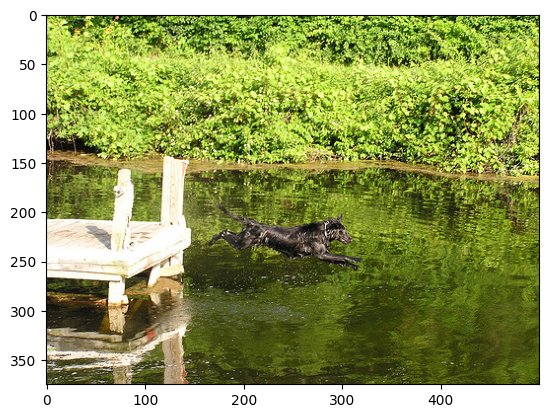

Greedy: A black dog is swimming in the water .


In [ ]:
pic = list(encoding_test.keys())[7]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
def evaluate_model(descriptions, photos):
    actual,predicted=list(),list()
    for key,description in tqdm(descriptions.items()):
        photo=photos[images_path+'/'+key+'.jpg'].reshape((1,2048))
        caption=greedySearch(photo)
        predicted.append(caption.split())
        references = [d.split() for d in description]
        actual.append(references)
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate_model(test_descriptions,test_features)

* **Model_1 blue score:BLEU-1: 0.582590 BLEU-2: 0.366376 BLEU-3: 0.273183 BLEU-4: 0.153800**

In [ ]:
!pip install -q --upgrade keras-nlp

In [ ]:
from keras_nlp import models

# **MODEL ARCHITECTURE 2**

**Model contains RNN based decoder**

In [ ]:
import keras
from keras.layers import SimpleRNN, RepeatVector
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder1 = RepeatVector(max_length)(decoder1)  # Add this line
decoder2 = SimpleRNN(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 40, 200)   │    945,800 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 2048)      │          0 │ input_layer_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 40, 200)   │          0 │ embedding_6[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 40)        │          0 │ input_layer_17[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    524,544 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 256)       │    467,968 │ dropout_16[0][0], │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 512)       │          0 │ dense_15[0][0],   │
│ (Concatenate)       │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 40, 512)   │          0 │ concatenate_8[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_2        │ (None, 256)       │    196,864 │ repeat_vector[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 4729)      │  1,215,353 │ simple_rnn_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,350,529 (12.78 MB)

 Trainable params: 3,350,529 (12.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 15
batch_size =64
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - loss: 5.6527
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - loss: 4.0025
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - loss: 3.5751
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - loss: 3.3461
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - loss: 3.1828
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - loss: 3.0686
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - loss: 2.9865
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - loss: 2.9145
Epoch 9/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - loss: 2.8522
Epoch 10/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - loss: 2.7981
Epoch 11/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - loss: 2.7443
Epoch 12/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - loss: 2.6944
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - loss: 2.6490
Epoch 14/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - loss: 2.6150
Epoch 15/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 

In [ ]:
evaluate_model(test_descriptions,test_features)

100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]


BLEU-1: 0.562375
BLEU-2: 0.354126
BLEU-3: 0.264236
BLEU-4: 0.146971


In [ ]:
model.save_weights('model_2.weights.h5')

**Model 2 scores: BLEU-1: 0.562375 BLEU-2: 0.354126 BLEU-3: 0.264236 BLEU-4: 0.146971**

# Below is the attempt to create a Attention based RNN decoder, although failed to incorporate

In [ ]:
# Add attention layer to the deep learning network
from keras.layers import Layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

# **MODEL ARCHITECTURE 3**

In [ ]:
import keras
from keras.layers import GRU, RepeatVector
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder1 = RepeatVector(max_length)(decoder1)  # Add this line
#decoder2 = SimpleRNN(256, activation='relu')(decoder1)


RNN_layer = GRU(256,return_sequences=False)(decoder1)
#attention_layer = attention()(RNN_layer)
#outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
outputs = Dense(vocab_size, activation='softmax')(RNN_layer)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 40, 200)   │    945,800 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 2048)      │          0 │ input_layer_15[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 40, 200)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 40)        │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    524,544 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    467,968 │ dropout_12[0][0], │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 512)       │          0 │ dense_16[0][0],   │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 40, 512)   │          0 │ concatenate_11[0… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    591,360 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4729)      │  1,215,353 │ gru[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,745,025 (14.29 MB)

 Trainable params: 3,745,025 (14.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 15
batch_size =64
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - loss: 6.0328
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - loss: 5.0635
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - loss: 4.8527
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - loss: 4.5792
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - loss: 4.3060
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 462ms/step - loss: 4.0329
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - loss: 3.6941
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - loss: 3.4139
Epoch 9/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - loss: 3.2244
Epoch 10/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - loss: 3.0944
Epoch 11/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - loss: 2.9879
Epoch 12/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - loss: 2.9072
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - loss: 2.8306
Epoch 14/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - loss: 2.7736
Epoch 15/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 

In [ ]:
evaluate_model(test_descriptions,test_features)

100%|██████████| 1000/1000 [18:34<00:00,  1.11s/it]


BLEU-1: 0.562181
BLEU-2: 0.352961
BLEU-3: 0.259578
BLEU-4: 0.142033


**Model 3 scores:BLEU-1: 0.581903 BLEU-2: 0.368106 BLEU-3: 0.271571 BLEU-4: 0.150377**

In [ ]:
model.save_weights('model_3.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


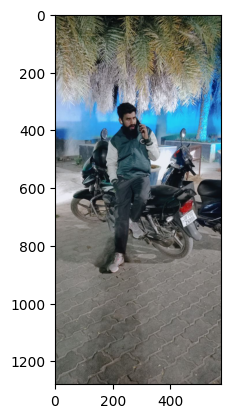

'A man is riding a bike on a dirt track .'

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

image_path = '/kaggle/input/mobile-images/photo_2024-04-08_10-43-03.jpg'
image = preprocess(image_path)
fea_vec = model_new.predict(image)
#fea_vec = fea_vec.reshape((1,2048))
# Load the image
img = Image.open(image_path)
# Convert the image to a numpy array
img_array = np.array(img)

# Now you can use img_array with matplotlib
plt.imshow(img_array)
plt.show()
#model.load_weights('/kaggle/working/model_3.weights.h5')
greedySearch(fea_vec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


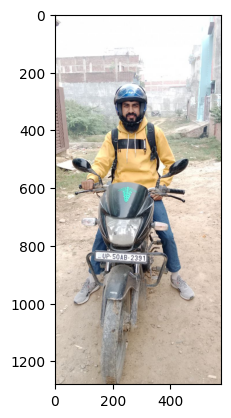

'A man in a red shirt and jeans is riding a bike on a dirt track .'

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

image_path = '/kaggle/input/mobile-images/photo_2024-04-08_16-26-24.jpg'
image = preprocess(image_path)
fea_vec = model_new.predict(image)
#fea_vec = fea_vec.reshape((1,2048))
# Load the image
img = Image.open(image_path)
# Convert the image to a numpy array
img_array = np.array(img)

# Now you can use img_array with matplotlib
plt.imshow(img_array)
plt.show()
#model.load_weights('/kaggle/working/model_3.weights.h5')
greedySearch(fea_vec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


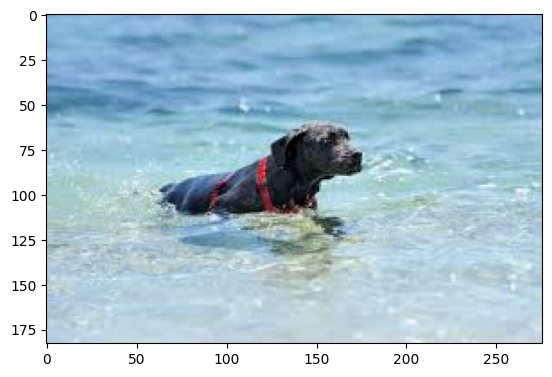

'A black dog is running through the water .'

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
image_path = '/kaggle/input/dog-images/download (1).jpg'
image = preprocess(image_path)
fea_vec = model_new.predict(image)
#fea_vec = fea_vec.reshape((1,2048))
# Load the image
img = Image.open(image_path)
# Convert the image to a numpy array
img_array = np.array(img)

# Now you can use img_array with matplotlib
plt.imshow(img_array)
plt.show()
#model.load_weights('/kaggle/working/model_3.weights.h5')
greedySearch(fea_vec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


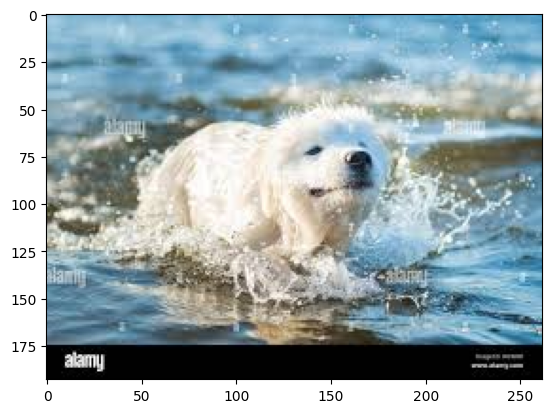

'A white dog is swimming in the water .'

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
image_path = '/kaggle/input/dog-images/download.jpg'
image = preprocess(image_path)
fea_vec = model_new.predict(image)
#fea_vec = fea_vec.reshape((1,2048))
# Load the image
img = Image.open(image_path)
# Convert the image to a numpy array
img_array = np.array(img)

# Now you can use img_array with matplotlib
plt.imshow(img_array)
plt.show()
#model.load_weights('/kaggle/working/model_3.weights.h5')
greedySearch(fea_vec)